# 1. Define function


**Reclassification Logic**

The `relclass` function reclassifies ESA CCI land cover classes into simplified categories:

| New Class | Description | Original ESA CCI Classes |
|-----------|-------------|--------------------------|
| 1 | Cropland | 10-40 |
| 2 | Forest | 50-90, 160, 170 |
| 3 | Savanna | 100, 110 |
| 4 | Shrub | 120, 121, 122 |
| 5 | Grassland and Arid Ecosystem | 130-153 |
| 6 | Wetland | 180 |
| 7 | Built-up | 190 |
| 8 | Bare Area and Ice | 200, 201, 202 |
| 9 | Water | 210 |


In [1]:
import xarray as xr
import glob
import os
import numpy as np
from dask.diagnostics import ProgressBar

#220


def relclass(landcover_ds):
    # 创建一个新的Dataset
    reclassed = landcover_ds.copy()
    
    # 获取要处理的变量
    landcover_da = landcover_ds['lccs_class']

    #cropland
    cropland_mask = (landcover_da >= 10) & (landcover_da <= 40)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~cropland_mask, 1)
    
    #forest
    forest_mask = ((landcover_da >= 50) & (landcover_da <= 90)) \
                  | (landcover_da == 160) | (landcover_da == 170)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~forest_mask, 2)
    
    #savanna
    savanna_mask = (landcover_da == 100) | (landcover_da == 110)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~savanna_mask, 3)
    
    #shrub
    shrub_mask = (landcover_da == 120) | (landcover_da == 121) | (landcover_da == 122)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~shrub_mask, 4)
    
    #grassland and arid ecosystem
    grassland_mask = ((landcover_da >= 130) & (landcover_da <= 153))
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~grassland_mask, 5)
    
    #wetland
    wetland_mask = (landcover_da == 180)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~wetland_mask, 6)
    
    #built-up
    built_up_mask = (landcover_da == 190)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~built_up_mask, 7)
    
    #bare area and ice
    bare_area_mask = (landcover_da == 200) | (landcover_da == 201) | (landcover_da == 202) |(landcover_da == 220)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~bare_area_mask, 8)
    
    #water
    water_mask = (landcover_da == 210)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~water_mask, 9)

    return reclassed

# 定义统一的chunk大小
CHUNK_SIZE = 'auto'  # 使用文件原有的chunk大小

# 读取数据
lc = xr.open_dataset(
    'data/merged_lccs.nc',
    chunks=CHUNK_SIZE
)

# 重分类处理
reclassed_ds = relclass(lc)

# 设置输出路径
output_path = 'output/recalss_lccs.nc'

# 使用dask进行计算并保存
with ProgressBar():
    reclassed_ds.to_netcdf(
        output_path,
        engine="netcdf4",
        format="NETCDF4",
        encoding={"lccs_class": {"zlib": True, "complevel": 4}},
        compute=True
    )

print("Saved the reclassed result!")

[########################################] | 100% Completed | 57m 11s
Saved the reclassed result!


## Create California place as example

In [2]:
import xarray as xr
import glob
import os
import numpy as np
from dask.diagnostics import ProgressBar
reclassed_ds= xr.open_dataset('output/merged_lccs.nc')
# Define California's approximate bounding box
ca_lat_min, ca_lat_max = 32.5, 42.0  # California's latitude range
ca_lon_min, ca_lon_max = -124.5, -114.0  # California's longitude range

# Slice the dataset to California's extent
ca_ds = reclassed_ds.sel(
    lat=slice(ca_lat_max, ca_lat_min),  # Note: slice goes from high to low for lat
    lon=slice(ca_lon_min, ca_lon_max)
)
bare_area_mask = (ca_ds["lccs_class"] == 220)
ca_ds['lccs_class'] = ca_ds['lccs_class'].where(~bare_area_mask, 8)
ca_ds.compute()
# Display the sliced dataset
ca_ds.where(ca_ds["lccs_class"] <= 9).to_netcdf("output/ca_lccs.nc")

# 2. Investigation (Study Area)

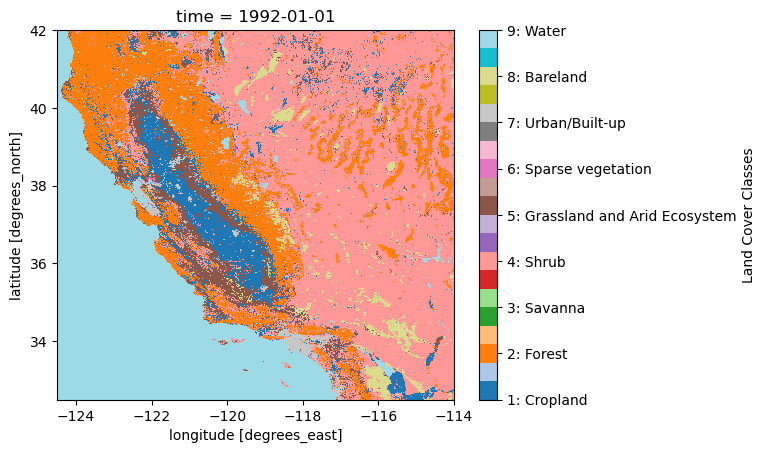

In [16]:
import xarray as xr
import glob
import os
import numpy as np

ca_ds = xr.open_dataset("output/ca_lccs.nc")

# Create a dictionary mapping class values to descriptions
class_descriptions = {
    1: 'Cropland',
    2: 'Forest', 
    3: 'Savanna',
    4: 'Shrub',
    5: 'Grassland and Arid Ecosystem',
    6: 'Sparse vegetation',
    7: 'Urban/Built-up',
    8: 'Bareland',
    9: 'Water'
}

# Plot with custom colormap and legend
plot = ca_ds["lccs_class"].isel(time=0).plot(
    cmap='tab20',
    add_colorbar=True,
    cbar_kwargs={
        'label': 'Land Cover Classes',
        'ticks': list(class_descriptions.keys()),
        'format': lambda x, p: f'{int(x)}: {class_descriptions.get(int(x), "")}'
    }
)





### 农田

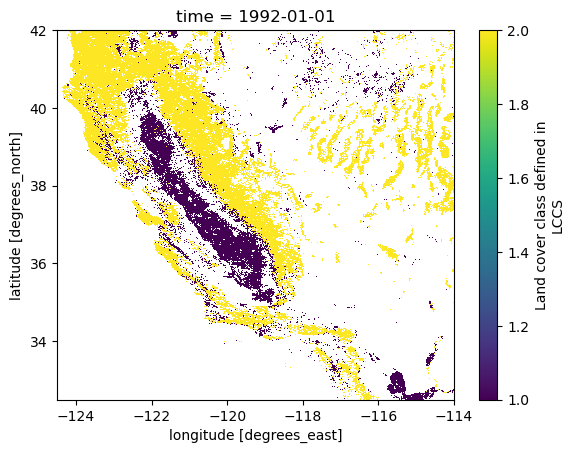

In [17]:
plot = ca_ds["lccs_class"].where((ca_ds["lccs_class"] == 1) | (ca_ds["lccs_class"] == 2)).isel(time=0).plot()

# 3. Identify the cropland abandonment



Given : xarray dataset rc，
It has following properties:
    Dimensions: time: 31 lat: 3420  lon: 3780
    data variable (int)：lccs_class
    Where cropland is 1.
    

Let 非人工区域(non_artificial)为（not cropland (1) nor 7 (built-up)）

Create a new dataset Output: rc_new it has "abandonment_year", abandonment_duration


1. 检测所有满足下列条件的像素生成mask:
   1. 所有年里存在农田(1)
   2. non_artificial 的数量应>=5
   3. 至少存在第一个点是1，第二个点是non_artificial的情况


2. 根据这个mask， 遍历所有满足条件的像素tqdm(series)

For each point in series:
    duration=0
    year=None
    if the point is cropland:
        if duration >=5 and (not year):
            save result.
            下一个点
        else:
            year=对应的年份
            duration=0
    if the point is non_artificial and (year not None):
        duration=duration+1
        
    if是最后一个点并且 duration >=5,
        save result.


Save the result of year into a variable  "abandonment_year"
Save the result of duration into variable  "abandonment_duration"





In [18]:
rc = xr.open_dataset("output/ca_lccs.nc")

In [19]:
rc

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 31, lat: 3420, lon: 3780)
Coordinates:
  * lat         (lat) float64 27kB 42.0 42.0 41.99 41.99 ... 32.51 32.5 32.5
  * lon         (lon) float64 30kB -124.5 -124.5 -124.5 ... -114.0 -114.0 -114.0
  * time        (time) datetime64[ns] 248B 1992-01-01 1993-01-01 ... 2022-01-01
Data variables:
    lccs_class  (time, lat, lon) float32 2GB ...
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [20]:
import numpy as np
import xarray as xr
from tqdm import tqdm
# Create mask where:
# 1. Cropland exists in any year
# 2. Non-artificial areas >= 5 years
# 3. At least one sequence starts with cropland followed by non-artificial
cropland_exists = (rc.lccs_class == 1).any(dim='time')
non_artificial = ((rc.lccs_class != 1) & (rc.lccs_class != 7)).sum(dim='time') >= 5

# Check for cropland followed by non-artificial
has_sequence = False
for t in range(len(rc.time)-1):
    cropland_t = rc.lccs_class.isel(time=t) == 1
    non_artificial_t1 = (rc.lccs_class.isel(time=t+1) != 1) & (rc.lccs_class.isel(time=t+1) != 7)
    has_sequence = has_sequence | (cropland_t & non_artificial_t1)

mask = cropland_exists & non_artificial & has_sequence


# Create output arrays initialized with NaN
abandonment_year = np.full(rc.lccs_class.shape[1:], np.nan)
abandonment_duration = np.full(rc.lccs_class.shape[1:], np.nan)

# Get indices of masked pixels
lat_idx, lon_idx = np.where(mask)

# Iterate through masked pixels
for i, j in tqdm(zip(lat_idx, lon_idx), total=len(lat_idx)):
    duration = 0
    year = None
    series = rc.lccs_class.isel(lat=i, lon=j)
    for t, val in enumerate(series):
        if val == 1 :  # Cropland 
            if duration >= 5 and year is None:  # Save previous abandonment if duration met and no abandonment started
                abandonment_year[i,j] = year
                abandonment_duration[i,j] = duration
                break
            else:
                year = rc.time[t].values
                duration = 0
        elif ((val != 1) and (val != 7)) and year is not None:  # Non-artificial after cropland
            duration += 1
        else:  # Reset if we see cropland again before 5 years
            year = None
            duration = 0
        # Check last point
        if t == len(series)-1 and duration >= 5:
            abandonment_year[i,j] = year
            abandonment_duration[i,j] = duration

# Create new dataset with results
rc_new = xr.Dataset(
    data_vars={
        'abandonment_year': (['lat', 'lon'], abandonment_year),
        'abandonment_duration': (['lat', 'lon'], abandonment_duration)
    },
    coords={
        'lat': rc.lat,
        'lon': rc.lon
    }
)


100%|██████████| 31678/31678 [07:05<00:00, 74.39it/s]


Number of non-NaN points: 30776


array([1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
      dtype=float32)

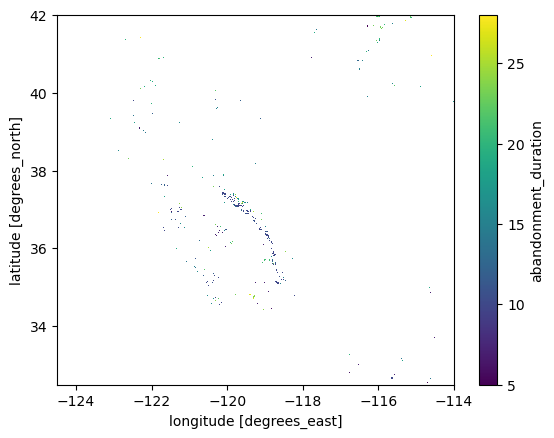

In [22]:
print(f"Number of non-NaN points: {np.count_nonzero(~np.isnan(rc_new['abandonment_duration']))}")
rc_new["abandonment_duration"].plot()


# Find first non-NaN point coordinates
valid_idx = np.where(~np.isnan(rc_new['abandonment_duration']))
example_i, example_j = valid_idx[0][0], valid_idx[1][0]

rc_new.isel(lat=example_i, lon=example_j)
rc["lccs_class"].isel(lat=example_i, lon=example_j).values


In [26]:
rc_new["abandonment_year"].isel(lat=example_i, lon=example_j)

<xarray.DataArray 'abandonment_year' ()> Size: 8B
array(8.836128e+17)
Coordinates:
    lat      float64 8B 42.0
    lon      float64 8B -116.1

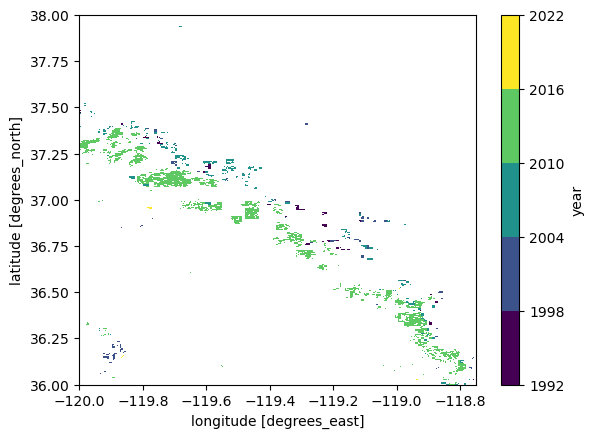

In [33]:
# Create 5 bins for years between 1992-2022
rc_new["abandonment_year"].astype('datetime64[ns]').dt.year.sel(lon=slice(-120,-118.75), lat=slice(38,36)).plot(
    cmap='viridis',
    levels=[1992, 1998, 2004, 2010, 2016, 2022]  # Split into 5 intervals
)



In [1]:
rc["lccs_class"].isel(time=1).sel(lon=slice(-120,-118.75), lat=slice(38,36)).where(rc["lccs_class"].isel(time=1) == 1).plot()

NameError: name 'rc' is not defined

# 将撂荒耕地重分配用于光伏发电及其减排效应评估

## Main Target:

观察在撂荒耕地再利用过程中太阳能光伏产生的碳效应权衡（结合有意思的观察修改故事线应当突出哪方面）

Highlight:

1. Introduce a spatial-temporal dynamic model to visualize the abatement potential of photovoltaic installation provided by abandonment cropland.

2. First attempt to measure the climate mitigation trade-offs in semi-agrivoltaics（非全完农业光伏，自己创造一个概念） along global abandoned cropland reallocation.

3. Though natural-based restroration strategy could be more cost-effective and work for climate change in the long-term, we emphasize development-based strategy could achieve co-benefits in a more expected way.


（主线逻辑：solar photovoltaic在《巴黎气候协定》中被认为是促进能源转型、实现气候目标的主要路径之一。然而，由于可再生能源功率密度比化石燃料低几个数量级，大规模进行太阳能光伏铺设需要占用大量土地资源，中国、美国等许多国家已经出现了剧烈土地竞争。在不同土地利用类型中，农田被认为是最有潜力也是最适宜进行太阳能光伏铺设的[[1]](https://www.nature.com/articles/s41598-019-47803-3)[[2]](https://iopscience.iop.org/article/10.1088/1748-9326/accc47/meta)，据测算，全球农业仅需要贡献1%面积即可满足全球能源需求。然而，最近研究表明，实际公共事业运行中光伏土地利用效率比理论估计低六倍，不仅如此，额外的生物多样性损失、水资源浪费、粮食产能损失也会导致其余可持续发展目标trade-off。除了采用农业光伏改良实现用途复合、采用钙钛矿电池等先进技术提升能量密度等直接降低土地竞争，研究农业空间显示优化策略更为cost-effective与重要。特别是随着撂荒成为全球农业土地利用的新现象，撂荒耕地再利用已经成为重要研究热点，但在撂荒耕地上实施半农业光伏改造的潜力被长期低估。

（光伏对于空间的要求...）由于撂荒耕地空间以避免直接与城镇化、保障粮食安全目标等相竞争，同时也能够满足太阳能光伏设备需要的地理环境因素。）

### 1、识别可用于太阳能光伏撂荒耕地时空演变特征
    Gap: 

    Research content: 
    1) **How much abandonment cropland could provide for solar photovoltaic installation in the future?**
    This 

    2) **Where the solar photovoltaic should be installed, to see if their is some model to quantify the suitability.**

    3) **Whether the abandonment land shoud be recultivated?

计算思路1：
构建一个二维策略博弈矩阵，生成单个像素的决策矩阵，但是需要把光伏期望收益与复垦期望效益进行比较（需要将2050收益贴现到当下时间节点）。其中，自然演化情景作为逼近纳什均衡一种可能（即忽视适宜性（成本）、都不接受，表示需要按照历史趋势，推演这些撂荒的extent会转化为什么【有可能是】）

    
### 2、农业光伏的理论减排效应核算
（故事逻辑：根据光伏测算理论上的碳效应）

    （需要进一步Literatue一下是否与第一部分有所重合）


### 3、农业光伏策略带来的机会性碳汇损失
（故事逻辑：将农业光伏策略与naturial-based strategy对比，观察在大规模森林植被恢复与自然演化趋势两种情景下固碳效应的变化趋势，测算农业光伏的机会性成本）

此时已经不再考虑适宜性，直接假设所有的光伏用地转化为森林植被恢复（林地）带来的碳汇效应

Background:
    use xarray open dataset as 'rc' 
    land cover refers to 'lccs_class'
    the year is from 1992 to 2022
    non-artificial land means valus is not equal to '1' or '7'
    cropland pixel value is 1

data: 
    1) ESA land use and land cover maps
    2) GLC_FCS30 land use and land cover maps 
    3) 
abandonment request:
    1）extract cropland mask to ；
    2）5 consecutive years remain non-artificial land 
    3）record the first year of abandonment and duration 

## Methods

### 1、cropland abandonment extent in 2022 the histroic duration

Given: use xarray, use tqdm, 'ds_ca' is xarray.Dataset (time:31,lat:3420,long:3780), which has variables 'lccs_class'. The value 1 is cropland. Let 非人工区域(non_artificial)为（not cropland (1) nor 7 (built-up).

Create a new dataset Output: 'rc_new' it has "abandonment_year", "abandonment_duration", "currently_abandonment" "historical_cultivation"variables.

create a mask, where:

1. at least 5 years of non-artificial land 
2. cropland exist 
3. starts with cropland and followed by 2 years non-artificial land 
4. starts with non-artificial land and followed by 4 years non-artificial

Then, use final mask to extract data from 'ds_ca'and perform abandonment calculation: 

for a sequence,
duration=0
current=false
abandonment_year=None
recultivation=false
    if a point is cropland:
        if abandonment_year is not none and duration>=5:
            recultivation=true
            save results
        else 
            abandonment_year = current year + 1
            duration=0
            move to next year 

    if a pixel in next year is non-artifical and abandonment_year is not none:
        duration+1

    if a pixel is built-up land and duration>=5:
        save results   

    if 遍历到了最后一个点2022年，并且 duration>=5
        current=true
        save results

###  2、Microclimate-informed PV efficiency model 

$${\color{Orange}(1-\alpha-\varepsilon) R_{\downarrow}^{sun}+L_{\downarrow}^{sky}+L_{\uparrow}^{g}-2 L^{p}-2 q_{c o n v}=0,} $$

each parameter denotes as:
$\varepsilon$ denotes the efficiency of the solar panel（太阳能电池效率）；
$\alpha$ denotes PV panel surface albedo（光伏表面反射率）；$R_{\downarrow}^{sun}$ denotes shortwave radiation from the sun(短波辐射)
$L_{\downarrow}^{sky}$ refers to the integral longwave radiation reaching the solar module（长波辐射）；

$$L_{\downarrow}^{s k y}=1.24 \sigma\left(\frac{e_{a}}{T_{a}}\right)^{\frac{1}{7}} T_{a}^{4}$$



式中， $e_a$  表示实测水汽压（百帕）， $T_a$  为实测气温（开尔文）， $\sigma = 5.670367 \times 10^{-8} \, \text{kg} \cdot \text{s}^{-1} \cdot \text{K}^{-4}$  为斯特藩-玻尔兹曼常数。来自地面的入射长波辐射采用理想黑体模型进行表征：



$$L_{\uparrow}^{g} = T_g^4,$$
式中$T_g^4$ 表示地表温度。光伏板的长波辐射被模拟为黑体辐射
$$L^p = \sigma T_p^4,$$
其中T_p为光伏板温度。光伏板的对流冷却过程采用总体输送方程描述：  
q_conv = h(T_p - T_a) ， (5)  
此处对流传热系数h通过经验公式估算[33]：  
h = (k/l) 0.036 (u l/υ)^0.8 Pr^{1/3} ， (6)  
（说明：公式中关键物理量保留国际标准符号，如υ为运动粘度，Pr为普朗特数，l为特征长度，u为风速。技术术语采用《工程热力学名词》审定版标准译法，公式排版遵循中文科技文献规范。）


<details >
                  <summary>Deeply thought for 41 s</summary>
                  <blockquote><p>好的，我现在需要帮助用户将论文中的公式转化为Markdown格式。首先，我需要仔细查看用户提供的论文内容，找到相关的公式部分。</p>
<p>用户提供的论文中，方法部分有一个PV效率模型的公式，具体是方程（1）。根据上下文，这个方程是能量平衡的结果，里面包含了一些变量和参数。我需要先确认这个方程的结构以及每个符号的意义，以确保转换的准确性。</p>
<p>方程（1）原文看起来是这样的：</p>
<p>−α−ε + + − − =<br />
↓ ↓↑<br />
(1 )R L L 2L 2q 0, (1)<br />
sun sky g p conv</p>
<p>不过，这样的排版可能在纯文本中有些混乱，我需要仔细解析。正确的方程应该是：</p>
<p>(1 - α - ε) R_sun + L_sky↓ + L_g↑ - 2L_p - 2q_conv = 0</p>
<p>这里，各个符号代表不同的能量项，比如α是反照率，ε是效率，R_sun是太阳辐射，L_sky是来自天空的长波辐射，L_g是地面反射的长波辐射，L_p是面板自身辐射，q_conv是对流冷却。</p>
<p>接下来，我需要用Markdown的数学公式语法来呈现这个方程。考虑到用户可能需要的是行内或独立的公式块，根据方程的重要性，这里应该用独立的块级公式，使用$$包围。</p>
<p>对于上标和下标，比如L_sky的下箭头，应该用L_{\text{sky}}↓或者L_{\text{sky}\downarrow}，但根据用户提供的原文，可能更准确的表示是L_sky的向下箭头，即L_{\text{sky}}^{\downarrow}。不过，原文中的符号可能需要更仔细的调整。例如，原文中的L_sky↓可能应表示为L_{\text{sky}}^\downarrow，而L_g↑则是L_g^\uparrow。</p>
<p>此外，变量如R_sun应该用斜体表示，即<mjx-container class="MathJax" jax="SVG" style="direction: ltr; position: relative;"><svg style="overflow: visible; min-height: 1px; min-width: 1px; vertical-align: -0.357ex;" xmlns="http://www.w3.org/2000/svg" width="4.314ex" height="1.902ex" role="img" focusable="false" viewBox="0 -683 1906.9 840.8" aria-hidden="true"><g stroke="currentColor" fill="currentColor" stroke-width="0" transform="scale(1,-1)"><g data-mml-node="math"><g data-mml-node="msub"><g data-mml-node="mi"><path data-c="1D445" d="M230 637Q203 637 198 638T193 649Q193 676 204 682Q206 683 378 683Q550 682 564 680Q620 672 658 652T712 606T733 563T739 529Q739 484 710 445T643 385T576 351T538 338L545 333Q612 295 612 223Q612 212 607 162T602 80V71Q602 53 603 43T614 25T640 16Q668 16 686 38T712 85Q717 99 720 102T735 105Q755 105 755 93Q755 75 731 36Q693 -21 641 -21H632Q571 -21 531 4T487 82Q487 109 502 166T517 239Q517 290 474 313Q459 320 449 321T378 323H309L277 193Q244 61 244 59Q244 55 245 54T252 50T269 48T302 46H333Q339 38 339 37T336 19Q332 6 326 0H311Q275 2 180 2Q146 2 117 2T71 2T50 1Q33 1 33 10Q33 12 36 24Q41 43 46 45Q50 46 61 46H67Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628Q287 635 230 637ZM630 554Q630 586 609 608T523 636Q521 636 500 636T462 637H440Q393 637 386 627Q385 624 352 494T319 361Q319 360 388 360Q466 361 492 367Q556 377 592 426Q608 449 619 486T630 554Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(792,-150) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="73" d="M295 316Q295 356 268 385T190 414Q154 414 128 401Q98 382 98 349Q97 344 98 336T114 312T157 287Q175 282 201 278T245 269T277 256Q294 248 310 236T342 195T359 133Q359 71 321 31T198 -10H190Q138 -10 94 26L86 19L77 10Q71 4 65 -1L54 -11H46H42Q39 -11 33 -5V74V132Q33 153 35 157T45 162H54Q66 162 70 158T75 146T82 119T101 77Q136 26 198 26Q295 26 295 104Q295 133 277 151Q257 175 194 187T111 210Q75 227 54 256T33 318Q33 357 50 384T93 424T143 442T187 447H198Q238 447 268 432L283 424L292 431Q302 440 314 448H322H326Q329 448 335 442V310L329 304H301Q295 310 295 316Z" style="stroke-width: 3;"/><path data-c="75" d="M383 58Q327 -10 256 -10H249Q124 -10 105 89Q104 96 103 226Q102 335 102 348T96 369Q86 385 36 385H25V408Q25 431 27 431L38 432Q48 433 67 434T105 436Q122 437 142 438T172 441T184 442H187V261Q188 77 190 64Q193 49 204 40Q224 26 264 26Q290 26 311 35T343 58T363 90T375 120T379 144Q379 145 379 161T380 201T380 248V315Q380 361 370 372T320 385H302V431Q304 431 378 436T457 442H464V264Q464 84 465 81Q468 61 479 55T524 46H542V0Q540 0 467 -5T390 -11H383V58Z" transform="translate(394,0)" style="stroke-width: 3;"/><path data-c="6E" d="M41 46H55Q94 46 102 60V68Q102 77 102 91T102 122T103 161T103 203Q103 234 103 269T102 328V351Q99 370 88 376T43 385H25V408Q25 431 27 431L37 432Q47 433 65 434T102 436Q119 437 138 438T167 441T178 442H181V402Q181 364 182 364T187 369T199 384T218 402T247 421T285 437Q305 442 336 442Q450 438 463 329Q464 322 464 190V104Q464 66 466 59T477 49Q498 46 526 46H542V0H534L510 1Q487 2 460 2T422 3Q319 3 310 0H302V46H318Q379 46 379 62Q380 64 380 200Q379 335 378 343Q372 371 358 385T334 402T308 404Q263 404 229 370Q202 343 195 315T187 232V168V108Q187 78 188 68T191 55T200 49Q221 46 249 46H265V0H257L234 1Q210 2 183 2T145 3Q42 3 33 0H25V46H41Z" transform="translate(950,0)" style="stroke-width: 3;"/></g></g></g></g></g></svg><mjx-assistive-mml unselectable="on" display="inline" style="top: 0px; left: 0px; clip: rect(1px, 1px, 1px, 1px); -webkit-touch-callout: none; -webkit-user-select: none; -khtml-user-select: none; -moz-user-select: none; -ms-user-select: none; user-select: none; position: absolute; padding: 1px 0px 0px 0px; border: 0px; display: block; width: auto; overflow: hidden;"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>R</mi><mrow data-mjx-texclass="ORD"><mtext>sun</mtext></mrow></msub></math></mjx-assistive-mml></mjx-container>，而像α和ε这样的希腊字母则用\alpha和\varepsilon。</p>
<p>综合这些因素，方程（1）转化为Markdown应该是：</p>
<mjx-container class="MathJax" jax="SVG" display="true" style="direction: ltr; display: block; text-align: center; margin: 1em 0; position: relative;"><svg style="overflow: visible; min-height: 1px; min-width: 1px; vertical-align: -1.044ex;" xmlns="http://www.w3.org/2000/svg" width="46.264ex" height="3.264ex" role="img" focusable="false" viewBox="0 -981.5 20448.7 1442.9" aria-hidden="true"><g stroke="currentColor" fill="currentColor" stroke-width="0" transform="scale(1,-1)"><g data-mml-node="math"><g data-mml-node="mo"><path data-c="28" d="M94 250Q94 319 104 381T127 488T164 576T202 643T244 695T277 729T302 750H315H319Q333 750 333 741Q333 738 316 720T275 667T226 581T184 443T167 250T184 58T225 -81T274 -167T316 -220T333 -241Q333 -250 318 -250H315H302L274 -226Q180 -141 137 -14T94 250Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(389,0)"><path data-c="31" d="M213 578L200 573Q186 568 160 563T102 556H83V602H102Q149 604 189 617T245 641T273 663Q275 666 285 666Q294 666 302 660V361L303 61Q310 54 315 52T339 48T401 46H427V0H416Q395 3 257 3Q121 3 100 0H88V46H114Q136 46 152 46T177 47T193 50T201 52T207 57T213 61V578Z" style="stroke-width: 3;"/></g><g data-mml-node="mo" transform="translate(1111.2,0)"><path data-c="2212" d="M84 237T84 250T98 270H679Q694 262 694 250T679 230H98Q84 237 84 250Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(2111.4,0)"><path data-c="1D6FC" d="M34 156Q34 270 120 356T309 442Q379 442 421 402T478 304Q484 275 485 237V208Q534 282 560 374Q564 388 566 390T582 393Q603 393 603 385Q603 376 594 346T558 261T497 161L486 147L487 123Q489 67 495 47T514 26Q528 28 540 37T557 60Q559 67 562 68T577 70Q597 70 597 62Q597 56 591 43Q579 19 556 5T512 -10H505Q438 -10 414 62L411 69L400 61Q390 53 370 41T325 18T267 -2T203 -11Q124 -11 79 39T34 156ZM208 26Q257 26 306 47T379 90L403 112Q401 255 396 290Q382 405 304 405Q235 405 183 332Q156 292 139 224T121 120Q121 71 146 49T208 26Z" style="stroke-width: 3;"/></g><g data-mml-node="mo" transform="translate(2973.7,0)"><path data-c="2212" d="M84 237T84 250T98 270H679Q694 262 694 250T679 230H98Q84 237 84 250Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(3973.9,0)"><path data-c="1D700" d="M190 -22Q124 -22 76 11T27 107Q27 174 97 232L107 239L99 248Q76 273 76 304Q76 364 144 408T290 452H302Q360 452 405 421Q428 405 428 392Q428 381 417 369T391 356Q382 356 371 365T338 383T283 392Q217 392 167 368T116 308Q116 289 133 272Q142 263 145 262T157 264Q188 278 238 278H243Q308 278 308 247Q308 206 223 206Q177 206 142 219L132 212Q68 169 68 112Q68 39 201 39Q253 39 286 49T328 72T345 94T362 105Q376 103 376 88Q376 79 365 62T334 26T275 -8T190 -22Z" style="stroke-width: 3;"/></g><g data-mml-node="mo" transform="translate(4439.9,0)"><path data-c="29" d="M60 749L64 750Q69 750 74 750H86L114 726Q208 641 251 514T294 250Q294 182 284 119T261 12T224 -76T186 -143T145 -194T113 -227T90 -246Q87 -249 86 -250H74Q66 -250 63 -250T58 -247T55 -238Q56 -237 66 -225Q221 -64 221 250T66 725Q56 737 55 738Q55 746 60 749Z" style="stroke-width: 3;"/></g><g data-mml-node="msub" transform="translate(4828.9,0)"><g data-mml-node="mi"><path data-c="1D445" d="M230 637Q203 637 198 638T193 649Q193 676 204 682Q206 683 378 683Q550 682 564 680Q620 672 658 652T712 606T733 563T739 529Q739 484 710 445T643 385T576 351T538 338L545 333Q612 295 612 223Q612 212 607 162T602 80V71Q602 53 603 43T614 25T640 16Q668 16 686 38T712 85Q717 99 720 102T735 105Q755 105 755 93Q755 75 731 36Q693 -21 641 -21H632Q571 -21 531 4T487 82Q487 109 502 166T517 239Q517 290 474 313Q459 320 449 321T378 323H309L277 193Q244 61 244 59Q244 55 245 54T252 50T269 48T302 46H333Q339 38 339 37T336 19Q332 6 326 0H311Q275 2 180 2Q146 2 117 2T71 2T50 1Q33 1 33 10Q33 12 36 24Q41 43 46 45Q50 46 61 46H67Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628Q287 635 230 637ZM630 554Q630 586 609 608T523 636Q521 636 500 636T462 637H440Q393 637 386 627Q385 624 352 494T319 361Q319 360 388 360Q466 361 492 367Q556 377 592 426Q608 449 619 486T630 554Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(792,-150) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="73" d="M295 316Q295 356 268 385T190 414Q154 414 128 401Q98 382 98 349Q97 344 98 336T114 312T157 287Q175 282 201 278T245 269T277 256Q294 248 310 236T342 195T359 133Q359 71 321 31T198 -10H190Q138 -10 94 26L86 19L77 10Q71 4 65 -1L54 -11H46H42Q39 -11 33 -5V74V132Q33 153 35 157T45 162H54Q66 162 70 158T75 146T82 119T101 77Q136 26 198 26Q295 26 295 104Q295 133 277 151Q257 175 194 187T111 210Q75 227 54 256T33 318Q33 357 50 384T93 424T143 442T187 447H198Q238 447 268 432L283 424L292 431Q302 440 314 448H322H326Q329 448 335 442V310L329 304H301Q295 310 295 316Z" style="stroke-width: 3;"/><path data-c="75" d="M383 58Q327 -10 256 -10H249Q124 -10 105 89Q104 96 103 226Q102 335 102 348T96 369Q86 385 36 385H25V408Q25 431 27 431L38 432Q48 433 67 434T105 436Q122 437 142 438T172 441T184 442H187V261Q188 77 190 64Q193 49 204 40Q224 26 264 26Q290 26 311 35T343 58T363 90T375 120T379 144Q379 145 379 161T380 201T380 248V315Q380 361 370 372T320 385H302V431Q304 431 378 436T457 442H464V264Q464 84 465 81Q468 61 479 55T524 46H542V0Q540 0 467 -5T390 -11H383V58Z" transform="translate(394,0)" style="stroke-width: 3;"/><path data-c="6E" d="M41 46H55Q94 46 102 60V68Q102 77 102 91T102 122T103 161T103 203Q103 234 103 269T102 328V351Q99 370 88 376T43 385H25V408Q25 431 27 431L37 432Q47 433 65 434T102 436Q119 437 138 438T167 441T178 442H181V402Q181 364 182 364T187 369T199 384T218 402T247 421T285 437Q305 442 336 442Q450 438 463 329Q464 322 464 190V104Q464 66 466 59T477 49Q498 46 526 46H542V0H534L510 1Q487 2 460 2T422 3Q319 3 310 0H302V46H318Q379 46 379 62Q380 64 380 200Q379 335 378 343Q372 371 358 385T334 402T308 404Q263 404 229 370Q202 343 195 315T187 232V168V108Q187 78 188 68T191 55T200 49Q221 46 249 46H265V0H257L234 1Q210 2 183 2T145 3Q42 3 33 0H25V46H41Z" transform="translate(950,0)" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mo" transform="translate(6958,0)"><path data-c="2B" d="M56 237T56 250T70 270H369V420L370 570Q380 583 389 583Q402 583 409 568V270H707Q722 262 722 250T707 230H409V-68Q401 -82 391 -82H389H387Q375 -82 369 -68V230H70Q56 237 56 250Z" style="stroke-width: 3;"/></g><g data-mml-node="msubsup" transform="translate(7958.2,0)"><g data-mml-node="mi"><path data-c="1D43F" d="M228 637Q194 637 192 641Q191 643 191 649Q191 673 202 682Q204 683 217 683Q271 680 344 680Q485 680 506 683H518Q524 677 524 674T522 656Q517 641 513 637H475Q406 636 394 628Q387 624 380 600T313 336Q297 271 279 198T252 88L243 52Q243 48 252 48T311 46H328Q360 46 379 47T428 54T478 72T522 106T564 161Q580 191 594 228T611 270Q616 273 628 273H641Q647 264 647 262T627 203T583 83T557 9Q555 4 553 3T537 0T494 -1Q483 -1 418 -1T294 0H116Q32 0 32 10Q32 17 34 24Q39 43 44 45Q48 46 59 46H65Q92 46 125 49Q139 52 144 61Q147 65 216 339T285 628Q285 635 228 637Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(714,490.8) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mo"><path data-c="2193" d="M473 86Q483 86 483 67Q483 63 483 61T483 56T481 53T480 50T478 48T474 47T470 46T464 44Q428 35 391 14T316 -55T264 -168Q264 -170 263 -173T262 -180T261 -184Q259 -194 251 -194Q242 -194 238 -176T221 -121T180 -49Q169 -34 155 -21T125 2T95 20T67 33T44 42T27 47L21 49Q17 53 17 67Q17 87 28 87Q33 87 42 84Q158 52 223 -45L230 -55V312Q230 391 230 482T229 591Q229 662 231 676T243 693Q244 694 251 694Q264 692 270 679V-55L277 -45Q307 1 353 33T430 76T473 86Z" style="stroke-width: 3;"/></g></g><g data-mml-node="TeXAtom" transform="translate(714,-317.1) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="73" d="M295 316Q295 356 268 385T190 414Q154 414 128 401Q98 382 98 349Q97 344 98 336T114 312T157 287Q175 282 201 278T245 269T277 256Q294 248 310 236T342 195T359 133Q359 71 321 31T198 -10H190Q138 -10 94 26L86 19L77 10Q71 4 65 -1L54 -11H46H42Q39 -11 33 -5V74V132Q33 153 35 157T45 162H54Q66 162 70 158T75 146T82 119T101 77Q136 26 198 26Q295 26 295 104Q295 133 277 151Q257 175 194 187T111 210Q75 227 54 256T33 318Q33 357 50 384T93 424T143 442T187 447H198Q238 447 268 432L283 424L292 431Q302 440 314 448H322H326Q329 448 335 442V310L329 304H301Q295 310 295 316Z" style="stroke-width: 3;"/><path data-c="6B" d="M36 46H50Q89 46 97 60V68Q97 77 97 91T97 124T98 167T98 217T98 272T98 329Q98 366 98 407T98 482T98 542T97 586T97 603Q94 622 83 628T38 637H20V660Q20 683 22 683L32 684Q42 685 61 686T98 688Q115 689 135 690T165 693T176 694H179V463L180 233L240 287Q300 341 304 347Q310 356 310 364Q310 383 289 385H284V431H293Q308 428 412 428Q475 428 484 431H489V385H476Q407 380 360 341Q286 278 286 274Q286 273 349 181T420 79Q434 60 451 53T500 46H511V0H505Q496 3 418 3Q322 3 307 0H299V46H306Q330 48 330 65Q330 72 326 79Q323 84 276 153T228 222L176 176V120V84Q176 65 178 59T189 49Q210 46 238 46H254V0H246Q231 3 137 3T28 0H20V46H36Z" transform="translate(394,0)" style="stroke-width: 3;"/><path data-c="79" d="M69 -66Q91 -66 104 -80T118 -116Q118 -134 109 -145T91 -160Q84 -163 97 -166Q104 -168 111 -168Q131 -168 148 -159T175 -138T197 -106T213 -75T225 -43L242 0L170 183Q150 233 125 297Q101 358 96 368T80 381Q79 382 78 382Q66 385 34 385H19V431H26L46 430Q65 430 88 429T122 428Q129 428 142 428T171 429T200 430T224 430L233 431H241V385H232Q183 385 185 366L286 112Q286 113 332 227L376 341V350Q376 365 366 373T348 383T334 385H331V431H337H344Q351 431 361 431T382 430T405 429T422 429Q477 429 503 431H508V385H497Q441 380 422 345Q420 343 378 235T289 9T227 -131Q180 -204 113 -204Q69 -204 44 -177T19 -116Q19 -89 35 -78T69 -66Z" transform="translate(922,0)" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mo" transform="translate(9969.8,0)"><path data-c="2B" d="M56 237T56 250T70 270H369V420L370 570Q380 583 389 583Q402 583 409 568V270H707Q722 262 722 250T707 230H409V-68Q401 -82 391 -82H389H387Q375 -82 369 -68V230H70Q56 237 56 250Z" style="stroke-width: 3;"/></g><g data-mml-node="msubsup" transform="translate(10970,0)"><g data-mml-node="mi"><path data-c="1D43F" d="M228 637Q194 637 192 641Q191 643 191 649Q191 673 202 682Q204 683 217 683Q271 680 344 680Q485 680 506 683H518Q524 677 524 674T522 656Q517 641 513 637H475Q406 636 394 628Q387 624 380 600T313 336Q297 271 279 198T252 88L243 52Q243 48 252 48T311 46H328Q360 46 379 47T428 54T478 72T522 106T564 161Q580 191 594 228T611 270Q616 273 628 273H641Q647 264 647 262T627 203T583 83T557 9Q555 4 553 3T537 0T494 -1Q483 -1 418 -1T294 0H116Q32 0 32 10Q32 17 34 24Q39 43 44 45Q48 46 59 46H65Q92 46 125 49Q139 52 144 61Q147 65 216 339T285 628Q285 635 228 637Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(714,413) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mo"><path data-c="2191" d="M27 414Q17 414 17 433Q17 437 17 439T17 444T19 447T20 450T22 452T26 453T30 454T36 456Q80 467 120 494T180 549Q227 607 238 678Q240 694 251 694Q259 694 261 684Q261 677 265 659T284 608T320 549Q340 525 363 507T405 479T440 463T467 455T479 451Q483 447 483 433Q483 413 472 413Q467 413 458 416Q342 448 277 545L270 555V-179Q262 -193 252 -193H250H248Q236 -193 230 -179V555L223 545Q192 499 146 467T70 424T27 414Z" style="stroke-width: 3;"/></g></g><g data-mml-node="TeXAtom" transform="translate(714,-247) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="67" d="M329 409Q373 453 429 453Q459 453 472 434T485 396Q485 382 476 371T449 360Q416 360 412 390Q410 404 415 411Q415 412 416 414V415Q388 412 363 393Q355 388 355 386Q355 385 359 381T368 369T379 351T388 325T392 292Q392 230 343 187T222 143Q172 143 123 171Q112 153 112 133Q112 98 138 81Q147 75 155 75T227 73Q311 72 335 67Q396 58 431 26Q470 -13 470 -72Q470 -139 392 -175Q332 -206 250 -206Q167 -206 107 -175Q29 -140 29 -75Q29 -39 50 -15T92 18L103 24Q67 55 67 108Q67 155 96 193Q52 237 52 292Q52 355 102 398T223 442Q274 442 318 416L329 409ZM299 343Q294 371 273 387T221 404Q192 404 171 388T145 343Q142 326 142 292Q142 248 149 227T179 192Q196 182 222 182Q244 182 260 189T283 207T294 227T299 242Q302 258 302 292T299 343ZM403 -75Q403 -50 389 -34T348 -11T299 -2T245 0H218Q151 0 138 -6Q118 -15 107 -34T95 -74Q95 -84 101 -97T122 -127T170 -155T250 -167Q319 -167 361 -139T403 -75Z" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mo" transform="translate(12309.8,0)"><path data-c="2212" d="M84 237T84 250T98 270H679Q694 262 694 250T679 230H98Q84 237 84 250Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(13310,0)"><path data-c="32" d="M109 429Q82 429 66 447T50 491Q50 562 103 614T235 666Q326 666 387 610T449 465Q449 422 429 383T381 315T301 241Q265 210 201 149L142 93L218 92Q375 92 385 97Q392 99 409 186V189H449V186Q448 183 436 95T421 3V0H50V19V31Q50 38 56 46T86 81Q115 113 136 137Q145 147 170 174T204 211T233 244T261 278T284 308T305 340T320 369T333 401T340 431T343 464Q343 527 309 573T212 619Q179 619 154 602T119 569T109 550Q109 549 114 549Q132 549 151 535T170 489Q170 464 154 447T109 429Z" style="stroke-width: 3;"/></g><g data-mml-node="msub" transform="translate(13810,0)"><g data-mml-node="mi"><path data-c="1D43F" d="M228 637Q194 637 192 641Q191 643 191 649Q191 673 202 682Q204 683 217 683Q271 680 344 680Q485 680 506 683H518Q524 677 524 674T522 656Q517 641 513 637H475Q406 636 394 628Q387 624 380 600T313 336Q297 271 279 198T252 88L243 52Q243 48 252 48T311 46H328Q360 46 379 47T428 54T478 72T522 106T564 161Q580 191 594 228T611 270Q616 273 628 273H641Q647 264 647 262T627 203T583 83T557 9Q555 4 553 3T537 0T494 -1Q483 -1 418 -1T294 0H116Q32 0 32 10Q32 17 34 24Q39 43 44 45Q48 46 59 46H65Q92 46 125 49Q139 52 144 61Q147 65 216 339T285 628Q285 635 228 637Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(714,-150) scale(0.707)"><path data-c="1D45D" d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z" style="stroke-width: 3;"/></g></g><g data-mml-node="mo" transform="translate(15151.9,0)"><path data-c="2212" d="M84 237T84 250T98 270H679Q694 262 694 250T679 230H98Q84 237 84 250Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(16152.1,0)"><path data-c="32" d="M109 429Q82 429 66 447T50 491Q50 562 103 614T235 666Q326 666 387 610T449 465Q449 422 429 383T381 315T301 241Q265 210 201 149L142 93L218 92Q375 92 385 97Q392 99 409 186V189H449V186Q448 183 436 95T421 3V0H50V19V31Q50 38 56 46T86 81Q115 113 136 137Q145 147 170 174T204 211T233 244T261 278T284 308T305 340T320 369T333 401T340 431T343 464Q343 527 309 573T212 619Q179 619 154 602T119 569T109 550Q109 549 114 549Q132 549 151 535T170 489Q170 464 154 447T109 429Z" style="stroke-width: 3;"/></g><g data-mml-node="msub" transform="translate(16652.1,0)"><g data-mml-node="mi"><path data-c="1D45E" d="M33 157Q33 258 109 349T280 441Q340 441 372 389Q373 390 377 395T388 406T404 418Q438 442 450 442Q454 442 457 439T460 434Q460 425 391 149Q320 -135 320 -139Q320 -147 365 -148H390Q396 -156 396 -157T393 -175Q389 -188 383 -194H370Q339 -192 262 -192Q234 -192 211 -192T174 -192T157 -193Q143 -193 143 -185Q143 -182 145 -170Q149 -154 152 -151T172 -148Q220 -148 230 -141Q238 -136 258 -53T279 32Q279 33 272 29Q224 -10 172 -10Q117 -10 75 30T33 157ZM352 326Q329 405 277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q233 26 290 98L298 109L352 326Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(479,-150) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="63" d="M370 305T349 305T313 320T297 358Q297 381 312 396Q317 401 317 402T307 404Q281 408 258 408Q209 408 178 376Q131 329 131 219Q131 137 162 90Q203 29 272 29Q313 29 338 55T374 117Q376 125 379 127T395 129H409Q415 123 415 120Q415 116 411 104T395 71T366 33T318 2T249 -11Q163 -11 99 53T34 214Q34 318 99 383T250 448T370 421T404 357Q404 334 387 320Z" style="stroke-width: 3;"/><path data-c="6F" d="M28 214Q28 309 93 378T250 448Q340 448 405 380T471 215Q471 120 407 55T250 -10Q153 -10 91 57T28 214ZM250 30Q372 30 372 193V225V250Q372 272 371 288T364 326T348 362T317 390T268 410Q263 411 252 411Q222 411 195 399Q152 377 139 338T126 246V226Q126 130 145 91Q177 30 250 30Z" transform="translate(444,0)" style="stroke-width: 3;"/><path data-c="6E" d="M41 46H55Q94 46 102 60V68Q102 77 102 91T102 122T103 161T103 203Q103 234 103 269T102 328V351Q99 370 88 376T43 385H25V408Q25 431 27 431L37 432Q47 433 65 434T102 436Q119 437 138 438T167 441T178 442H181V402Q181 364 182 364T187 369T199 384T218 402T247 421T285 437Q305 442 336 442Q450 438 463 329Q464 322 464 190V104Q464 66 466 59T477 49Q498 46 526 46H542V0H534L510 1Q487 2 460 2T422 3Q319 3 310 0H302V46H318Q379 46 379 62Q380 64 380 200Q379 335 378 343Q372 371 358 385T334 402T308 404Q263 404 229 370Q202 343 195 315T187 232V168V108Q187 78 188 68T191 55T200 49Q221 46 249 46H265V0H257L234 1Q210 2 183 2T145 3Q42 3 33 0H25V46H41Z" transform="translate(944,0)" style="stroke-width: 3;"/><path data-c="76" d="M338 431Q344 429 422 429Q479 429 503 431H508V385H497Q439 381 423 345Q421 341 356 172T288 -2Q283 -11 263 -11Q244 -11 239 -2Q99 359 98 364Q93 378 82 381T43 385H19V431H25L33 430Q41 430 53 430T79 430T104 429T122 428Q217 428 232 431H240V385H226Q187 384 184 370Q184 366 235 234L286 102L377 341V349Q377 363 367 372T349 383T335 385H331V431H338Z" transform="translate(1500,0)" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mo" transform="translate(18892.9,0)"><path data-c="3D" d="M56 347Q56 360 70 367H707Q722 359 722 347Q722 336 708 328L390 327H72Q56 332 56 347ZM56 153Q56 168 72 173H708Q722 163 722 153Q722 140 707 133H70Q56 140 56 153Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(19948.7,0)"><path data-c="30" d="M96 585Q152 666 249 666Q297 666 345 640T423 548Q460 465 460 320Q460 165 417 83Q397 41 362 16T301 -15T250 -22Q224 -22 198 -16T137 16T82 83Q39 165 39 320Q39 494 96 585ZM321 597Q291 629 250 629Q208 629 178 597Q153 571 145 525T137 333Q137 175 145 125T181 46Q209 16 250 16Q290 16 318 46Q347 76 354 130T362 333Q362 478 354 524T321 597Z" style="stroke-width: 3;"/></g></g></g></svg><mjx-assistive-mml unselectable="on" display="block" style="top: 0px; left: 0px; clip: rect(1px, 1px, 1px, 1px); -webkit-touch-callout: none; -webkit-user-select: none; -khtml-user-select: none; -moz-user-select: none; -ms-user-select: none; user-select: none; position: absolute; padding: 1px 0px 0px 0px; border: 0px; display: block; overflow: hidden; width: 100%;"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mo stretchy="false">(</mo><mn>1</mn><mo>−</mo><mi>α</mi><mo>−</mo><mi>ε</mi><mo stretchy="false">)</mo><msub><mi>R</mi><mrow data-mjx-texclass="ORD"><mtext>sun</mtext></mrow></msub><mo>+</mo><msubsup><mi>L</mi><mrow data-mjx-texclass="ORD"><mtext>sky</mtext></mrow><mrow data-mjx-texclass="ORD"><mo stretchy="false">↓</mo></mrow></msubsup><mo>+</mo><msubsup><mi>L</mi><mrow data-mjx-texclass="ORD"><mtext>g</mtext></mrow><mrow data-mjx-texclass="ORD"><mo stretchy="false">↑</mo></mrow></msubsup><mo>−</mo><mn>2</mn><msub><mi>L</mi><mi>p</mi></msub><mo>−</mo><mn>2</mn><msub><mi>q</mi><mrow data-mjx-texclass="ORD"><mtext>conv</mtext></mrow></msub><mo>=</mo><mn>0</mn></math></mjx-assistive-mml></mjx-container><p>然后，用户可能需要其他公式的转换，比如方程（2）、（3）等。例如，方程（2）是关于来自天空的长波辐射的模型：</p>
<p>L_sky↓ = 1.24 * (e_a / T_a)^(1/7) * σ * T_a^4</p>
<p>转化为Markdown：</p>
<mjx-container class="MathJax" jax="SVG" display="true" style="direction: ltr; display: block; text-align: center; margin: 1em 0; position: relative;"><svg style="overflow: visible; min-height: 1px; min-width: 1px; vertical-align: -2.148ex;" xmlns="http://www.w3.org/2000/svg" width="24.356ex" height="6.01ex" role="img" focusable="false" viewBox="0 -1706.9 10765.1 2656.4" aria-hidden="true"><g stroke="currentColor" fill="currentColor" stroke-width="0" transform="scale(1,-1)"><g data-mml-node="math"><g data-mml-node="msubsup"><g data-mml-node="mi"><path data-c="1D43F" d="M228 637Q194 637 192 641Q191 643 191 649Q191 673 202 682Q204 683 217 683Q271 680 344 680Q485 680 506 683H518Q524 677 524 674T522 656Q517 641 513 637H475Q406 636 394 628Q387 624 380 600T313 336Q297 271 279 198T252 88L243 52Q243 48 252 48T311 46H328Q360 46 379 47T428 54T478 72T522 106T564 161Q580 191 594 228T611 270Q616 273 628 273H641Q647 264 647 262T627 203T583 83T557 9Q555 4 553 3T537 0T494 -1Q483 -1 418 -1T294 0H116Q32 0 32 10Q32 17 34 24Q39 43 44 45Q48 46 59 46H65Q92 46 125 49Q139 52 144 61Q147 65 216 339T285 628Q285 635 228 637Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(714,490.8) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mo"><path data-c="2193" d="M473 86Q483 86 483 67Q483 63 483 61T483 56T481 53T480 50T478 48T474 47T470 46T464 44Q428 35 391 14T316 -55T264 -168Q264 -170 263 -173T262 -180T261 -184Q259 -194 251 -194Q242 -194 238 -176T221 -121T180 -49Q169 -34 155 -21T125 2T95 20T67 33T44 42T27 47L21 49Q17 53 17 67Q17 87 28 87Q33 87 42 84Q158 52 223 -45L230 -55V312Q230 391 230 482T229 591Q229 662 231 676T243 693Q244 694 251 694Q264 692 270 679V-55L277 -45Q307 1 353 33T430 76T473 86Z" style="stroke-width: 3;"/></g></g><g data-mml-node="TeXAtom" transform="translate(714,-317.1) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="73" d="M295 316Q295 356 268 385T190 414Q154 414 128 401Q98 382 98 349Q97 344 98 336T114 312T157 287Q175 282 201 278T245 269T277 256Q294 248 310 236T342 195T359 133Q359 71 321 31T198 -10H190Q138 -10 94 26L86 19L77 10Q71 4 65 -1L54 -11H46H42Q39 -11 33 -5V74V132Q33 153 35 157T45 162H54Q66 162 70 158T75 146T82 119T101 77Q136 26 198 26Q295 26 295 104Q295 133 277 151Q257 175 194 187T111 210Q75 227 54 256T33 318Q33 357 50 384T93 424T143 442T187 447H198Q238 447 268 432L283 424L292 431Q302 440 314 448H322H326Q329 448 335 442V310L329 304H301Q295 310 295 316Z" style="stroke-width: 3;"/><path data-c="6B" d="M36 46H50Q89 46 97 60V68Q97 77 97 91T97 124T98 167T98 217T98 272T98 329Q98 366 98 407T98 482T98 542T97 586T97 603Q94 622 83 628T38 637H20V660Q20 683 22 683L32 684Q42 685 61 686T98 688Q115 689 135 690T165 693T176 694H179V463L180 233L240 287Q300 341 304 347Q310 356 310 364Q310 383 289 385H284V431H293Q308 428 412 428Q475 428 484 431H489V385H476Q407 380 360 341Q286 278 286 274Q286 273 349 181T420 79Q434 60 451 53T500 46H511V0H505Q496 3 418 3Q322 3 307 0H299V46H306Q330 48 330 65Q330 72 326 79Q323 84 276 153T228 222L176 176V120V84Q176 65 178 59T189 49Q210 46 238 46H254V0H246Q231 3 137 3T28 0H20V46H36Z" transform="translate(394,0)" style="stroke-width: 3;"/><path data-c="79" d="M69 -66Q91 -66 104 -80T118 -116Q118 -134 109 -145T91 -160Q84 -163 97 -166Q104 -168 111 -168Q131 -168 148 -159T175 -138T197 -106T213 -75T225 -43L242 0L170 183Q150 233 125 297Q101 358 96 368T80 381Q79 382 78 382Q66 385 34 385H19V431H26L46 430Q65 430 88 429T122 428Q129 428 142 428T171 429T200 430T224 430L233 431H241V385H232Q183 385 185 366L286 112Q286 113 332 227L376 341V350Q376 365 366 373T348 383T334 385H331V431H337H344Q351 431 361 431T382 430T405 429T422 429Q477 429 503 431H508V385H497Q441 380 422 345Q420 343 378 235T289 9T227 -131Q180 -204 113 -204Q69 -204 44 -177T19 -116Q19 -89 35 -78T69 -66Z" transform="translate(922,0)" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mo" transform="translate(2067.1,0)"><path data-c="3D" d="M56 347Q56 360 70 367H707Q722 359 722 347Q722 336 708 328L390 327H72Q56 332 56 347ZM56 153Q56 168 72 173H708Q722 163 722 153Q722 140 707 133H70Q56 140 56 153Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(3122.9,0)"><path data-c="31" d="M213 578L200 573Q186 568 160 563T102 556H83V602H102Q149 604 189 617T245 641T273 663Q275 666 285 666Q294 666 302 660V361L303 61Q310 54 315 52T339 48T401 46H427V0H416Q395 3 257 3Q121 3 100 0H88V46H114Q136 46 152 46T177 47T193 50T201 52T207 57T213 61V578Z" style="stroke-width: 3;"/><path data-c="2E" d="M78 60Q78 84 95 102T138 120Q162 120 180 104T199 61Q199 36 182 18T139 0T96 17T78 60Z" transform="translate(500,0)" style="stroke-width: 3;"/><path data-c="32" d="M109 429Q82 429 66 447T50 491Q50 562 103 614T235 666Q326 666 387 610T449 465Q449 422 429 383T381 315T301 241Q265 210 201 149L142 93L218 92Q375 92 385 97Q392 99 409 186V189H449V186Q448 183 436 95T421 3V0H50V19V31Q50 38 56 46T86 81Q115 113 136 137Q145 147 170 174T204 211T233 244T261 278T284 308T305 340T320 369T333 401T340 431T343 464Q343 527 309 573T212 619Q179 619 154 602T119 569T109 550Q109 549 114 549Q132 549 151 535T170 489Q170 464 154 447T109 429Z" transform="translate(778,0)" style="stroke-width: 3;"/><path data-c="34" d="M462 0Q444 3 333 3Q217 3 199 0H190V46H221Q241 46 248 46T265 48T279 53T286 61Q287 63 287 115V165H28V211L179 442Q332 674 334 675Q336 677 355 677H373L379 671V211H471V165H379V114Q379 73 379 66T385 54Q393 47 442 46H471V0H462ZM293 211V545L74 212L183 211H293Z" transform="translate(1278,0)" style="stroke-width: 3;"/></g><g data-mml-node="msup" transform="translate(4900.9,0)"><g data-mml-node="mrow"><g data-mml-node="mo" transform="translate(0 -0.5)"><path data-c="28" d="M701 -940Q701 -943 695 -949H664Q662 -947 636 -922T591 -879T537 -818T475 -737T412 -636T350 -511T295 -362T250 -186T221 17T209 251Q209 962 573 1361Q596 1386 616 1405T649 1437T664 1450H695Q701 1444 701 1441Q701 1436 681 1415T629 1356T557 1261T476 1118T400 927T340 675T308 359Q306 321 306 250Q306 -139 400 -430T690 -924Q701 -936 701 -940Z" style="stroke-width: 3;"/></g><g data-mml-node="mfrac" transform="translate(736,0)"><g data-mml-node="msub" transform="translate(279,676)"><g data-mml-node="mi"><path data-c="1D452" d="M39 168Q39 225 58 272T107 350T174 402T244 433T307 442H310Q355 442 388 420T421 355Q421 265 310 237Q261 224 176 223Q139 223 138 221Q138 219 132 186T125 128Q125 81 146 54T209 26T302 45T394 111Q403 121 406 121Q410 121 419 112T429 98T420 82T390 55T344 24T281 -1T205 -11Q126 -11 83 42T39 168ZM373 353Q367 405 305 405Q272 405 244 391T199 357T170 316T154 280T149 261Q149 260 169 260Q282 260 327 284T373 353Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(499,-150) scale(0.707)"><path data-c="1D44E" d="M33 157Q33 258 109 349T280 441Q331 441 370 392Q386 422 416 422Q429 422 439 414T449 394Q449 381 412 234T374 68Q374 43 381 35T402 26Q411 27 422 35Q443 55 463 131Q469 151 473 152Q475 153 483 153H487Q506 153 506 144Q506 138 501 117T481 63T449 13Q436 0 417 -8Q409 -10 393 -10Q359 -10 336 5T306 36L300 51Q299 52 296 50Q294 48 292 46Q233 -10 172 -10Q117 -10 75 30T33 157ZM351 328Q351 334 346 350T323 385T277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q217 26 254 59T298 110Q300 114 325 217T351 328Z" style="stroke-width: 3;"/></g></g><g data-mml-node="msub" transform="translate(220,-686)"><g data-mml-node="mi"><path data-c="1D447" d="M40 437Q21 437 21 445Q21 450 37 501T71 602L88 651Q93 669 101 677H569H659Q691 677 697 676T704 667Q704 661 687 553T668 444Q668 437 649 437Q640 437 637 437T631 442L629 445Q629 451 635 490T641 551Q641 586 628 604T573 629Q568 630 515 631Q469 631 457 630T439 622Q438 621 368 343T298 60Q298 48 386 46Q418 46 427 45T436 36Q436 31 433 22Q429 4 424 1L422 0Q419 0 415 0Q410 0 363 1T228 2Q99 2 64 0H49Q43 6 43 9T45 27Q49 40 55 46H83H94Q174 46 189 55Q190 56 191 56Q196 59 201 76T241 233Q258 301 269 344Q339 619 339 625Q339 630 310 630H279Q212 630 191 624Q146 614 121 583T67 467Q60 445 57 441T43 437H40Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(617,-150) scale(0.707)"><path data-c="1D44E" d="M33 157Q33 258 109 349T280 441Q331 441 370 392Q386 422 416 422Q429 422 439 414T449 394Q449 381 412 234T374 68Q374 43 381 35T402 26Q411 27 422 35Q443 55 463 131Q469 151 473 152Q475 153 483 153H487Q506 153 506 144Q506 138 501 117T481 63T449 13Q436 0 417 -8Q409 -10 393 -10Q359 -10 336 5T306 36L300 51Q299 52 296 50Q294 48 292 46Q233 -10 172 -10Q117 -10 75 30T33 157ZM351 328Q351 334 346 350T323 385T277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q217 26 254 59T298 110Q300 114 325 217T351 328Z" style="stroke-width: 3;"/></g></g><rect width="1241.1" height="60" x="120" y="220"/></g><g data-mml-node="mo" transform="translate(2217.1,0) translate(0 -0.5)"><path data-c="29" d="M34 1438Q34 1446 37 1448T50 1450H56H71Q73 1448 99 1423T144 1380T198 1319T260 1238T323 1137T385 1013T440 864T485 688T514 485T526 251Q526 134 519 53Q472 -519 162 -860Q139 -885 119 -904T86 -936T71 -949H56Q43 -949 39 -947T34 -937Q88 -883 140 -813Q428 -430 428 251Q428 453 402 628T338 922T245 1146T145 1309T46 1425Q44 1427 42 1429T39 1433T36 1436L34 1438Z" style="stroke-width: 3;"/></g></g><g data-mml-node="TeXAtom" transform="translate(2986.1,1176.6) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mn"><path data-c="31" d="M213 578L200 573Q186 568 160 563T102 556H83V602H102Q149 604 189 617T245 641T273 663Q275 666 285 666Q294 666 302 660V361L303 61Q310 54 315 52T339 48T401 46H427V0H416Q395 3 257 3Q121 3 100 0H88V46H114Q136 46 152 46T177 47T193 50T201 52T207 57T213 61V578Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" data-mjx-texclass="ORD" transform="translate(500,0)"><g data-mml-node="mo"><path data-c="2F" d="M423 750Q432 750 438 744T444 730Q444 725 271 248T92 -240Q85 -250 75 -250Q68 -250 62 -245T56 -231Q56 -221 230 257T407 740Q411 750 423 750Z" style="stroke-width: 3;"/></g></g><g data-mml-node="mn" transform="translate(1000,0)"><path data-c="37" d="M55 458Q56 460 72 567L88 674Q88 676 108 676H128V672Q128 662 143 655T195 646T364 644H485V605L417 512Q408 500 387 472T360 435T339 403T319 367T305 330T292 284T284 230T278 162T275 80Q275 66 275 52T274 28V19Q270 2 255 -10T221 -22Q210 -22 200 -19T179 0T168 40Q168 198 265 368Q285 400 349 489L395 552H302Q128 552 119 546Q113 543 108 522T98 479L95 458V455H55V458Z" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mi" transform="translate(8997.6,0)"><path data-c="1D70E" d="M184 -11Q116 -11 74 34T31 147Q31 247 104 333T274 430Q275 431 414 431H552Q553 430 555 429T559 427T562 425T565 422T567 420T569 416T570 412T571 407T572 401Q572 357 507 357Q500 357 490 357T476 358H416L421 348Q439 310 439 263Q439 153 359 71T184 -11ZM361 278Q361 358 276 358Q152 358 115 184Q114 180 114 178Q106 141 106 117Q106 67 131 47T188 26Q242 26 287 73Q316 103 334 153T356 233T361 278Z" style="stroke-width: 3;"/></g><g data-mml-node="msubsup" transform="translate(9568.6,0)"><g data-mml-node="mi"><path data-c="1D447" d="M40 437Q21 437 21 445Q21 450 37 501T71 602L88 651Q93 669 101 677H569H659Q691 677 697 676T704 667Q704 661 687 553T668 444Q668 437 649 437Q640 437 637 437T631 442L629 445Q629 451 635 490T641 551Q641 586 628 604T573 629Q568 630 515 631Q469 631 457 630T439 622Q438 621 368 343T298 60Q298 48 386 46Q418 46 427 45T436 36Q436 31 433 22Q429 4 424 1L422 0Q419 0 415 0Q410 0 363 1T228 2Q99 2 64 0H49Q43 6 43 9T45 27Q49 40 55 46H83H94Q174 46 189 55Q190 56 191 56Q196 59 201 76T241 233Q258 301 269 344Q339 619 339 625Q339 630 310 630H279Q212 630 191 624Q146 614 121 583T67 467Q60 445 57 441T43 437H40Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(793,413) scale(0.707)"><path data-c="34" d="M462 0Q444 3 333 3Q217 3 199 0H190V46H221Q241 46 248 46T265 48T279 53T286 61Q287 63 287 115V165H28V211L179 442Q332 674 334 675Q336 677 355 677H373L379 671V211H471V165H379V114Q379 73 379 66T385 54Q393 47 442 46H471V0H462ZM293 211V545L74 212L183 211H293Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(617,-247) scale(0.707)"><path data-c="1D44E" d="M33 157Q33 258 109 349T280 441Q331 441 370 392Q386 422 416 422Q429 422 439 414T449 394Q449 381 412 234T374 68Q374 43 381 35T402 26Q411 27 422 35Q443 55 463 131Q469 151 473 152Q475 153 483 153H487Q506 153 506 144Q506 138 501 117T481 63T449 13Q436 0 417 -8Q409 -10 393 -10Q359 -10 336 5T306 36L300 51Q299 52 296 50Q294 48 292 46Q233 -10 172 -10Q117 -10 75 30T33 157ZM351 328Q351 334 346 350T323 385T277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q217 26 254 59T298 110Q300 114 325 217T351 328Z" style="stroke-width: 3;"/></g></g></g></g></svg><mjx-assistive-mml unselectable="on" display="block" style="top: 0px; left: 0px; clip: rect(1px, 1px, 1px, 1px); -webkit-touch-callout: none; -webkit-user-select: none; -khtml-user-select: none; -moz-user-select: none; -ms-user-select: none; user-select: none; position: absolute; padding: 1px 0px 0px 0px; border: 0px; display: block; overflow: hidden; width: 100%;"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><msubsup><mi>L</mi><mrow data-mjx-texclass="ORD"><mtext>sky</mtext></mrow><mrow data-mjx-texclass="ORD"><mo stretchy="false">↓</mo></mrow></msubsup><mo>=</mo><mn>1.24</mn><msup><mrow data-mjx-texclass="INNER"><mo data-mjx-texclass="OPEN">(</mo><mfrac><msub><mi>e</mi><mi>a</mi></msub><msub><mi>T</mi><mi>a</mi></msub></mfrac><mo data-mjx-texclass="CLOSE">)</mo></mrow><mrow data-mjx-texclass="ORD"><mn>1</mn><mrow data-mjx-texclass="ORD"><mo>/</mo></mrow><mn>7</mn></mrow></msup><mi>σ</mi><msubsup><mi>T</mi><mi>a</mi><mn>4</mn></msubsup></math></mjx-assistive-mml></mjx-container><p>同样，方程（3）是地面反射的长波辐射：</p>
<p>L_g↑ = σ * T_g^4</p>
<p>转化为：</p>
<mjx-container class="MathJax" jax="SVG" display="true" style="direction: ltr; display: block; text-align: center; margin: 1em 0; position: relative;"><svg style="overflow: visible; min-height: 1px; min-width: 1px; vertical-align: -0.888ex;" xmlns="http://www.w3.org/2000/svg" width="9.544ex" height="2.933ex" role="img" focusable="false" viewBox="0 -903.7 4218.7 1296.4" aria-hidden="true"><g stroke="currentColor" fill="currentColor" stroke-width="0" transform="scale(1,-1)"><g data-mml-node="math"><g data-mml-node="msubsup"><g data-mml-node="mi"><path data-c="1D43F" d="M228 637Q194 637 192 641Q191 643 191 649Q191 673 202 682Q204 683 217 683Q271 680 344 680Q485 680 506 683H518Q524 677 524 674T522 656Q517 641 513 637H475Q406 636 394 628Q387 624 380 600T313 336Q297 271 279 198T252 88L243 52Q243 48 252 48T311 46H328Q360 46 379 47T428 54T478 72T522 106T564 161Q580 191 594 228T611 270Q616 273 628 273H641Q647 264 647 262T627 203T583 83T557 9Q555 4 553 3T537 0T494 -1Q483 -1 418 -1T294 0H116Q32 0 32 10Q32 17 34 24Q39 43 44 45Q48 46 59 46H65Q92 46 125 49Q139 52 144 61Q147 65 216 339T285 628Q285 635 228 637Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(714,413) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mo"><path data-c="2191" d="M27 414Q17 414 17 433Q17 437 17 439T17 444T19 447T20 450T22 452T26 453T30 454T36 456Q80 467 120 494T180 549Q227 607 238 678Q240 694 251 694Q259 694 261 684Q261 677 265 659T284 608T320 549Q340 525 363 507T405 479T440 463T467 455T479 451Q483 447 483 433Q483 413 472 413Q467 413 458 416Q342 448 277 545L270 555V-179Q262 -193 252 -193H250H248Q236 -193 230 -179V555L223 545Q192 499 146 467T70 424T27 414Z" style="stroke-width: 3;"/></g></g><g data-mml-node="TeXAtom" transform="translate(714,-247) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="67" d="M329 409Q373 453 429 453Q459 453 472 434T485 396Q485 382 476 371T449 360Q416 360 412 390Q410 404 415 411Q415 412 416 414V415Q388 412 363 393Q355 388 355 386Q355 385 359 381T368 369T379 351T388 325T392 292Q392 230 343 187T222 143Q172 143 123 171Q112 153 112 133Q112 98 138 81Q147 75 155 75T227 73Q311 72 335 67Q396 58 431 26Q470 -13 470 -72Q470 -139 392 -175Q332 -206 250 -206Q167 -206 107 -175Q29 -140 29 -75Q29 -39 50 -15T92 18L103 24Q67 55 67 108Q67 155 96 193Q52 237 52 292Q52 355 102 398T223 442Q274 442 318 416L329 409ZM299 343Q294 371 273 387T221 404Q192 404 171 388T145 343Q142 326 142 292Q142 248 149 227T179 192Q196 182 222 182Q244 182 260 189T283 207T294 227T299 242Q302 258 302 292T299 343ZM403 -75Q403 -50 389 -34T348 -11T299 -2T245 0H218Q151 0 138 -6Q118 -15 107 -34T95 -74Q95 -84 101 -97T122 -127T170 -155T250 -167Q319 -167 361 -139T403 -75Z" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mo" transform="translate(1395.3,0)"><path data-c="3D" d="M56 347Q56 360 70 367H707Q722 359 722 347Q722 336 708 328L390 327H72Q56 332 56 347ZM56 153Q56 168 72 173H708Q722 163 722 153Q722 140 707 133H70Q56 140 56 153Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(2451.1,0)"><path data-c="1D70E" d="M184 -11Q116 -11 74 34T31 147Q31 247 104 333T274 430Q275 431 414 431H552Q553 430 555 429T559 427T562 425T565 422T567 420T569 416T570 412T571 407T572 401Q572 357 507 357Q500 357 490 357T476 358H416L421 348Q439 310 439 263Q439 153 359 71T184 -11ZM361 278Q361 358 276 358Q152 358 115 184Q114 180 114 178Q106 141 106 117Q106 67 131 47T188 26Q242 26 287 73Q316 103 334 153T356 233T361 278Z" style="stroke-width: 3;"/></g><g data-mml-node="msubsup" transform="translate(3022.1,0)"><g data-mml-node="mi"><path data-c="1D447" d="M40 437Q21 437 21 445Q21 450 37 501T71 602L88 651Q93 669 101 677H569H659Q691 677 697 676T704 667Q704 661 687 553T668 444Q668 437 649 437Q640 437 637 437T631 442L629 445Q629 451 635 490T641 551Q641 586 628 604T573 629Q568 630 515 631Q469 631 457 630T439 622Q438 621 368 343T298 60Q298 48 386 46Q418 46 427 45T436 36Q436 31 433 22Q429 4 424 1L422 0Q419 0 415 0Q410 0 363 1T228 2Q99 2 64 0H49Q43 6 43 9T45 27Q49 40 55 46H83H94Q174 46 189 55Q190 56 191 56Q196 59 201 76T241 233Q258 301 269 344Q339 619 339 625Q339 630 310 630H279Q212 630 191 624Q146 614 121 583T67 467Q60 445 57 441T43 437H40Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(793,413) scale(0.707)"><path data-c="34" d="M462 0Q444 3 333 3Q217 3 199 0H190V46H221Q241 46 248 46T265 48T279 53T286 61Q287 63 287 115V165H28V211L179 442Q332 674 334 675Q336 677 355 677H373L379 671V211H471V165H379V114Q379 73 379 66T385 54Q393 47 442 46H471V0H462ZM293 211V545L74 212L183 211H293Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(617,-247) scale(0.707)"><path data-c="1D454" d="M311 43Q296 30 267 15T206 0Q143 0 105 45T66 160Q66 265 143 353T314 442Q361 442 401 394L404 398Q406 401 409 404T418 412T431 419T447 422Q461 422 470 413T480 394Q480 379 423 152T363 -80Q345 -134 286 -169T151 -205Q10 -205 10 -137Q10 -111 28 -91T74 -71Q89 -71 102 -80T116 -111Q116 -121 114 -130T107 -144T99 -154T92 -162L90 -164H91Q101 -167 151 -167Q189 -167 211 -155Q234 -144 254 -122T282 -75Q288 -56 298 -13Q311 35 311 43ZM384 328L380 339Q377 350 375 354T369 368T359 382T346 393T328 402T306 405Q262 405 221 352Q191 313 171 233T151 117Q151 38 213 38Q269 38 323 108L331 118L384 328Z" style="stroke-width: 3;"/></g></g></g></g></svg><mjx-assistive-mml unselectable="on" display="block" style="top: 0px; left: 0px; clip: rect(1px, 1px, 1px, 1px); -webkit-touch-callout: none; -webkit-user-select: none; -khtml-user-select: none; -moz-user-select: none; -ms-user-select: none; user-select: none; position: absolute; padding: 1px 0px 0px 0px; border: 0px; display: block; overflow: hidden; width: 100%;"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><msubsup><mi>L</mi><mrow data-mjx-texclass="ORD"><mtext>g</mtext></mrow><mrow data-mjx-texclass="ORD"><mo stretchy="false">↑</mo></mrow></msubsup><mo>=</mo><mi>σ</mi><msubsup><mi>T</mi><mi>g</mi><mn>4</mn></msubsup></math></mjx-assistive-mml></mjx-container><p>方程（4）面板自身辐射：</p>
<p>L_p = σ * T_p^4</p>
<p>转化为：</p>
<mjx-container class="MathJax" jax="SVG" display="true" style="direction: ltr; display: block; text-align: center; margin: 1em 0; position: relative;"><svg style="overflow: visible; min-height: 1px; min-width: 1px; vertical-align: -0.869ex;" xmlns="http://www.w3.org/2000/svg" width="9.549ex" height="2.887ex" role="img" focusable="false" viewBox="0 -891.7 4220.8 1275.9" aria-hidden="true"><g stroke="currentColor" fill="currentColor" stroke-width="0" transform="scale(1,-1)"><g data-mml-node="math"><g data-mml-node="msub"><g data-mml-node="mi"><path data-c="1D43F" d="M228 637Q194 637 192 641Q191 643 191 649Q191 673 202 682Q204 683 217 683Q271 680 344 680Q485 680 506 683H518Q524 677 524 674T522 656Q517 641 513 637H475Q406 636 394 628Q387 624 380 600T313 336Q297 271 279 198T252 88L243 52Q243 48 252 48T311 46H328Q360 46 379 47T428 54T478 72T522 106T564 161Q580 191 594 228T611 270Q616 273 628 273H641Q647 264 647 262T627 203T583 83T557 9Q555 4 553 3T537 0T494 -1Q483 -1 418 -1T294 0H116Q32 0 32 10Q32 17 34 24Q39 43 44 45Q48 46 59 46H65Q92 46 125 49Q139 52 144 61Q147 65 216 339T285 628Q285 635 228 637Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(714,-150) scale(0.707)"><path data-c="1D45D" d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z" style="stroke-width: 3;"/></g></g><g data-mml-node="mo" transform="translate(1397.5,0)"><path data-c="3D" d="M56 347Q56 360 70 367H707Q722 359 722 347Q722 336 708 328L390 327H72Q56 332 56 347ZM56 153Q56 168 72 173H708Q722 163 722 153Q722 140 707 133H70Q56 140 56 153Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(2453.2,0)"><path data-c="1D70E" d="M184 -11Q116 -11 74 34T31 147Q31 247 104 333T274 430Q275 431 414 431H552Q553 430 555 429T559 427T562 425T565 422T567 420T569 416T570 412T571 407T572 401Q572 357 507 357Q500 357 490 357T476 358H416L421 348Q439 310 439 263Q439 153 359 71T184 -11ZM361 278Q361 358 276 358Q152 358 115 184Q114 180 114 178Q106 141 106 117Q106 67 131 47T188 26Q242 26 287 73Q316 103 334 153T356 233T361 278Z" style="stroke-width: 3;"/></g><g data-mml-node="msubsup" transform="translate(3024.2,0)"><g data-mml-node="mi"><path data-c="1D447" d="M40 437Q21 437 21 445Q21 450 37 501T71 602L88 651Q93 669 101 677H569H659Q691 677 697 676T704 667Q704 661 687 553T668 444Q668 437 649 437Q640 437 637 437T631 442L629 445Q629 451 635 490T641 551Q641 586 628 604T573 629Q568 630 515 631Q469 631 457 630T439 622Q438 621 368 343T298 60Q298 48 386 46Q418 46 427 45T436 36Q436 31 433 22Q429 4 424 1L422 0Q419 0 415 0Q410 0 363 1T228 2Q99 2 64 0H49Q43 6 43 9T45 27Q49 40 55 46H83H94Q174 46 189 55Q190 56 191 56Q196 59 201 76T241 233Q258 301 269 344Q339 619 339 625Q339 630 310 630H279Q212 630 191 624Q146 614 121 583T67 467Q60 445 57 441T43 437H40Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(793,413) scale(0.707)"><path data-c="34" d="M462 0Q444 3 333 3Q217 3 199 0H190V46H221Q241 46 248 46T265 48T279 53T286 61Q287 63 287 115V165H28V211L179 442Q332 674 334 675Q336 677 355 677H373L379 671V211H471V165H379V114Q379 73 379 66T385 54Q393 47 442 46H471V0H462ZM293 211V545L74 212L183 211H293Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(617,-247) scale(0.707)"><path data-c="1D45D" d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z" style="stroke-width: 3;"/></g></g></g></g></svg><mjx-assistive-mml unselectable="on" display="block" style="top: 0px; left: 0px; clip: rect(1px, 1px, 1px, 1px); -webkit-touch-callout: none; -webkit-user-select: none; -khtml-user-select: none; -moz-user-select: none; -ms-user-select: none; user-select: none; position: absolute; padding: 1px 0px 0px 0px; border: 0px; display: block; overflow: hidden; width: 100%;"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><msub><mi>L</mi><mi>p</mi></msub><mo>=</mo><mi>σ</mi><msubsup><mi>T</mi><mi>p</mi><mn>4</mn></msubsup></math></mjx-assistive-mml></mjx-container><p>方程（5）对流冷却：</p>
<p>q_conv = h * (T_p - T_a)</p>
<p>转化为：</p>
<mjx-container class="MathJax" jax="SVG" display="true" style="direction: ltr; display: block; text-align: center; margin: 1em 0; position: relative;"><svg style="overflow: visible; min-height: 1px; min-width: 1px; vertical-align: -0.65ex;" xmlns="http://www.w3.org/2000/svg" width="17.956ex" height="2.347ex" role="img" focusable="false" viewBox="0 -750 7936.7 1037.2" aria-hidden="true"><g stroke="currentColor" fill="currentColor" stroke-width="0" transform="scale(1,-1)"><g data-mml-node="math"><g data-mml-node="msub"><g data-mml-node="mi"><path data-c="1D45E" d="M33 157Q33 258 109 349T280 441Q340 441 372 389Q373 390 377 395T388 406T404 418Q438 442 450 442Q454 442 457 439T460 434Q460 425 391 149Q320 -135 320 -139Q320 -147 365 -148H390Q396 -156 396 -157T393 -175Q389 -188 383 -194H370Q339 -192 262 -192Q234 -192 211 -192T174 -192T157 -193Q143 -193 143 -185Q143 -182 145 -170Q149 -154 152 -151T172 -148Q220 -148 230 -141Q238 -136 258 -53T279 32Q279 33 272 29Q224 -10 172 -10Q117 -10 75 30T33 157ZM352 326Q329 405 277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q233 26 290 98L298 109L352 326Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(479,-150) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="63" d="M370 305T349 305T313 320T297 358Q297 381 312 396Q317 401 317 402T307 404Q281 408 258 408Q209 408 178 376Q131 329 131 219Q131 137 162 90Q203 29 272 29Q313 29 338 55T374 117Q376 125 379 127T395 129H409Q415 123 415 120Q415 116 411 104T395 71T366 33T318 2T249 -11Q163 -11 99 53T34 214Q34 318 99 383T250 448T370 421T404 357Q404 334 387 320Z" style="stroke-width: 3;"/><path data-c="6F" d="M28 214Q28 309 93 378T250 448Q340 448 405 380T471 215Q471 120 407 55T250 -10Q153 -10 91 57T28 214ZM250 30Q372 30 372 193V225V250Q372 272 371 288T364 326T348 362T317 390T268 410Q263 411 252 411Q222 411 195 399Q152 377 139 338T126 246V226Q126 130 145 91Q177 30 250 30Z" transform="translate(444,0)" style="stroke-width: 3;"/><path data-c="6E" d="M41 46H55Q94 46 102 60V68Q102 77 102 91T102 122T103 161T103 203Q103 234 103 269T102 328V351Q99 370 88 376T43 385H25V408Q25 431 27 431L37 432Q47 433 65 434T102 436Q119 437 138 438T167 441T178 442H181V402Q181 364 182 364T187 369T199 384T218 402T247 421T285 437Q305 442 336 442Q450 438 463 329Q464 322 464 190V104Q464 66 466 59T477 49Q498 46 526 46H542V0H534L510 1Q487 2 460 2T422 3Q319 3 310 0H302V46H318Q379 46 379 62Q380 64 380 200Q379 335 378 343Q372 371 358 385T334 402T308 404Q263 404 229 370Q202 343 195 315T187 232V168V108Q187 78 188 68T191 55T200 49Q221 46 249 46H265V0H257L234 1Q210 2 183 2T145 3Q42 3 33 0H25V46H41Z" transform="translate(944,0)" style="stroke-width: 3;"/><path data-c="76" d="M338 431Q344 429 422 429Q479 429 503 431H508V385H497Q439 381 423 345Q421 341 356 172T288 -2Q283 -11 263 -11Q244 -11 239 -2Q99 359 98 364Q93 378 82 381T43 385H19V431H25L33 430Q41 430 53 430T79 430T104 429T122 428Q217 428 232 431H240V385H226Q187 384 184 370Q184 366 235 234L286 102L377 341V349Q377 363 367 372T349 383T335 385H331V431H338Z" transform="translate(1500,0)" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mo" transform="translate(2240.8,0)"><path data-c="3D" d="M56 347Q56 360 70 367H707Q722 359 722 347Q722 336 708 328L390 327H72Q56 332 56 347ZM56 153Q56 168 72 173H708Q722 163 722 153Q722 140 707 133H70Q56 140 56 153Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(3296.6,0)"><path data-c="210E" d="M137 683Q138 683 209 688T282 694Q294 694 294 685Q294 674 258 534Q220 386 220 383Q220 381 227 388Q288 442 357 442Q411 442 444 415T478 336Q478 285 440 178T402 50Q403 36 407 31T422 26Q450 26 474 56T513 138Q516 149 519 151T535 153Q555 153 555 145Q555 144 551 130Q535 71 500 33Q466 -10 419 -10H414Q367 -10 346 17T325 74Q325 90 361 192T398 345Q398 404 354 404H349Q266 404 205 306L198 293L164 158Q132 28 127 16Q114 -11 83 -11Q69 -11 59 -2T48 16Q48 30 121 320L195 616Q195 629 188 632T149 637H128Q122 643 122 645T124 664Q129 683 137 683Z" style="stroke-width: 3;"/></g><g data-mml-node="mo" transform="translate(3872.6,0)"><path data-c="28" d="M94 250Q94 319 104 381T127 488T164 576T202 643T244 695T277 729T302 750H315H319Q333 750 333 741Q333 738 316 720T275 667T226 581T184 443T167 250T184 58T225 -81T274 -167T316 -220T333 -241Q333 -250 318 -250H315H302L274 -226Q180 -141 137 -14T94 250Z" style="stroke-width: 3;"/></g><g data-mml-node="msub" transform="translate(4261.6,0)"><g data-mml-node="mi"><path data-c="1D447" d="M40 437Q21 437 21 445Q21 450 37 501T71 602L88 651Q93 669 101 677H569H659Q691 677 697 676T704 667Q704 661 687 553T668 444Q668 437 649 437Q640 437 637 437T631 442L629 445Q629 451 635 490T641 551Q641 586 628 604T573 629Q568 630 515 631Q469 631 457 630T439 622Q438 621 368 343T298 60Q298 48 386 46Q418 46 427 45T436 36Q436 31 433 22Q429 4 424 1L422 0Q419 0 415 0Q410 0 363 1T228 2Q99 2 64 0H49Q43 6 43 9T45 27Q49 40 55 46H83H94Q174 46 189 55Q190 56 191 56Q196 59 201 76T241 233Q258 301 269 344Q339 619 339 625Q339 630 310 630H279Q212 630 191 624Q146 614 121 583T67 467Q60 445 57 441T43 437H40Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(617,-150) scale(0.707)"><path data-c="1D45D" d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z" style="stroke-width: 3;"/></g></g><g data-mml-node="mo" transform="translate(5506.5,0)"><path data-c="2212" d="M84 237T84 250T98 270H679Q694 262 694 250T679 230H98Q84 237 84 250Z" style="stroke-width: 3;"/></g><g data-mml-node="msub" transform="translate(6506.7,0)"><g data-mml-node="mi"><path data-c="1D447" d="M40 437Q21 437 21 445Q21 450 37 501T71 602L88 651Q93 669 101 677H569H659Q691 677 697 676T704 667Q704 661 687 553T668 444Q668 437 649 437Q640 437 637 437T631 442L629 445Q629 451 635 490T641 551Q641 586 628 604T573 629Q568 630 515 631Q469 631 457 630T439 622Q438 621 368 343T298 60Q298 48 386 46Q418 46 427 45T436 36Q436 31 433 22Q429 4 424 1L422 0Q419 0 415 0Q410 0 363 1T228 2Q99 2 64 0H49Q43 6 43 9T45 27Q49 40 55 46H83H94Q174 46 189 55Q190 56 191 56Q196 59 201 76T241 233Q258 301 269 344Q339 619 339 625Q339 630 310 630H279Q212 630 191 624Q146 614 121 583T67 467Q60 445 57 441T43 437H40Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(617,-150) scale(0.707)"><path data-c="1D44E" d="M33 157Q33 258 109 349T280 441Q331 441 370 392Q386 422 416 422Q429 422 439 414T449 394Q449 381 412 234T374 68Q374 43 381 35T402 26Q411 27 422 35Q443 55 463 131Q469 151 473 152Q475 153 483 153H487Q506 153 506 144Q506 138 501 117T481 63T449 13Q436 0 417 -8Q409 -10 393 -10Q359 -10 336 5T306 36L300 51Q299 52 296 50Q294 48 292 46Q233 -10 172 -10Q117 -10 75 30T33 157ZM351 328Q351 334 346 350T323 385T277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q217 26 254 59T298 110Q300 114 325 217T351 328Z" style="stroke-width: 3;"/></g></g><g data-mml-node="mo" transform="translate(7547.7,0)"><path data-c="29" d="M60 749L64 750Q69 750 74 750H86L114 726Q208 641 251 514T294 250Q294 182 284 119T261 12T224 -76T186 -143T145 -194T113 -227T90 -246Q87 -249 86 -250H74Q66 -250 63 -250T58 -247T55 -238Q56 -237 66 -225Q221 -64 221 250T66 725Q56 737 55 738Q55 746 60 749Z" style="stroke-width: 3;"/></g></g></g></svg><mjx-assistive-mml unselectable="on" display="block" style="top: 0px; left: 0px; clip: rect(1px, 1px, 1px, 1px); -webkit-touch-callout: none; -webkit-user-select: none; -khtml-user-select: none; -moz-user-select: none; -ms-user-select: none; user-select: none; position: absolute; padding: 1px 0px 0px 0px; border: 0px; display: block; overflow: hidden; width: 100%;"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><msub><mi>q</mi><mrow data-mjx-texclass="ORD"><mtext>conv</mtext></mrow></msub><mo>=</mo><mi>h</mi><mo stretchy="false">(</mo><msub><mi>T</mi><mi>p</mi></msub><mo>−</mo><msub><mi>T</mi><mi>a</mi></msub><mo stretchy="false">)</mo></math></mjx-assistive-mml></mjx-container><p>方程（6）对流换热系数：</p>
<p>h = 0.036 * (k_air / l_panel) * (u * l_panel / ν)^(4/5) * Pr^(1/3)</p>
<p>这里需要处理分数和上标：</p>
<mjx-container class="MathJax" jax="SVG" display="true" style="direction: ltr; display: block; text-align: center; margin: 1em 0; position: relative;"><svg style="overflow: visible; min-height: 1px; min-width: 1px; vertical-align: -2.202ex;" xmlns="http://www.w3.org/2000/svg" width="33.176ex" height="6.063ex" role="img" focusable="false" viewBox="0 -1706.9 14663.7 2680.1" aria-hidden="true"><g stroke="currentColor" fill="currentColor" stroke-width="0" transform="scale(1,-1)"><g data-mml-node="math"><g data-mml-node="mi"><path data-c="210E" d="M137 683Q138 683 209 688T282 694Q294 694 294 685Q294 674 258 534Q220 386 220 383Q220 381 227 388Q288 442 357 442Q411 442 444 415T478 336Q478 285 440 178T402 50Q403 36 407 31T422 26Q450 26 474 56T513 138Q516 149 519 151T535 153Q555 153 555 145Q555 144 551 130Q535 71 500 33Q466 -10 419 -10H414Q367 -10 346 17T325 74Q325 90 361 192T398 345Q398 404 354 404H349Q266 404 205 306L198 293L164 158Q132 28 127 16Q114 -11 83 -11Q69 -11 59 -2T48 16Q48 30 121 320L195 616Q195 629 188 632T149 637H128Q122 643 122 645T124 664Q129 683 137 683Z" style="stroke-width: 3;"/></g><g data-mml-node="mo" transform="translate(853.8,0)"><path data-c="3D" d="M56 347Q56 360 70 367H707Q722 359 722 347Q722 336 708 328L390 327H72Q56 332 56 347ZM56 153Q56 168 72 173H708Q722 163 722 153Q722 140 707 133H70Q56 140 56 153Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(1909.6,0)"><path data-c="30" d="M96 585Q152 666 249 666Q297 666 345 640T423 548Q460 465 460 320Q460 165 417 83Q397 41 362 16T301 -15T250 -22Q224 -22 198 -16T137 16T82 83Q39 165 39 320Q39 494 96 585ZM321 597Q291 629 250 629Q208 629 178 597Q153 571 145 525T137 333Q137 175 145 125T181 46Q209 16 250 16Q290 16 318 46Q347 76 354 130T362 333Q362 478 354 524T321 597Z" style="stroke-width: 3;"/><path data-c="2E" d="M78 60Q78 84 95 102T138 120Q162 120 180 104T199 61Q199 36 182 18T139 0T96 17T78 60Z" transform="translate(500,0)" style="stroke-width: 3;"/><path data-c="30" d="M96 585Q152 666 249 666Q297 666 345 640T423 548Q460 465 460 320Q460 165 417 83Q397 41 362 16T301 -15T250 -22Q224 -22 198 -16T137 16T82 83Q39 165 39 320Q39 494 96 585ZM321 597Q291 629 250 629Q208 629 178 597Q153 571 145 525T137 333Q137 175 145 125T181 46Q209 16 250 16Q290 16 318 46Q347 76 354 130T362 333Q362 478 354 524T321 597Z" transform="translate(778,0)" style="stroke-width: 3;"/><path data-c="33" d="M127 463Q100 463 85 480T69 524Q69 579 117 622T233 665Q268 665 277 664Q351 652 390 611T430 522Q430 470 396 421T302 350L299 348Q299 347 308 345T337 336T375 315Q457 262 457 175Q457 96 395 37T238 -22Q158 -22 100 21T42 130Q42 158 60 175T105 193Q133 193 151 175T169 130Q169 119 166 110T159 94T148 82T136 74T126 70T118 67L114 66Q165 21 238 21Q293 21 321 74Q338 107 338 175V195Q338 290 274 322Q259 328 213 329L171 330L168 332Q166 335 166 348Q166 366 174 366Q202 366 232 371Q266 376 294 413T322 525V533Q322 590 287 612Q265 626 240 626Q208 626 181 615T143 592T132 580H135Q138 579 143 578T153 573T165 566T175 555T183 540T186 520Q186 498 172 481T127 463Z" transform="translate(1278,0)" style="stroke-width: 3;"/><path data-c="36" d="M42 313Q42 476 123 571T303 666Q372 666 402 630T432 550Q432 525 418 510T379 495Q356 495 341 509T326 548Q326 592 373 601Q351 623 311 626Q240 626 194 566Q147 500 147 364L148 360Q153 366 156 373Q197 433 263 433H267Q313 433 348 414Q372 400 396 374T435 317Q456 268 456 210V192Q456 169 451 149Q440 90 387 34T253 -22Q225 -22 199 -14T143 16T92 75T56 172T42 313ZM257 397Q227 397 205 380T171 335T154 278T148 216Q148 133 160 97T198 39Q222 21 251 21Q302 21 329 59Q342 77 347 104T352 209Q352 289 347 316T329 361Q302 397 257 397Z" transform="translate(1778,0)" style="stroke-width: 3;"/></g><g data-mml-node="mfrac" transform="translate(4187.6,0)"><g data-mml-node="msub" transform="translate(520,676)"><g data-mml-node="mi"><path data-c="1D458" d="M121 647Q121 657 125 670T137 683Q138 683 209 688T282 694Q294 694 294 686Q294 679 244 477Q194 279 194 272Q213 282 223 291Q247 309 292 354T362 415Q402 442 438 442Q468 442 485 423T503 369Q503 344 496 327T477 302T456 291T438 288Q418 288 406 299T394 328Q394 353 410 369T442 390L458 393Q446 405 434 405H430Q398 402 367 380T294 316T228 255Q230 254 243 252T267 246T293 238T320 224T342 206T359 180T365 147Q365 130 360 106T354 66Q354 26 381 26Q429 26 459 145Q461 153 479 153H483Q499 153 499 144Q499 139 496 130Q455 -11 378 -11Q333 -11 305 15T277 90Q277 108 280 121T283 145Q283 167 269 183T234 206T200 217T182 220H180Q168 178 159 139T145 81T136 44T129 20T122 7T111 -2Q98 -11 83 -11Q66 -11 57 -1T48 16Q48 26 85 176T158 471L195 616Q196 629 188 632T149 637H144Q134 637 131 637T124 640T121 647Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(554,-150) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="61" d="M137 305T115 305T78 320T63 359Q63 394 97 421T218 448Q291 448 336 416T396 340Q401 326 401 309T402 194V124Q402 76 407 58T428 40Q443 40 448 56T453 109V145H493V106Q492 66 490 59Q481 29 455 12T400 -6T353 12T329 54V58L327 55Q325 52 322 49T314 40T302 29T287 17T269 6T247 -2T221 -8T190 -11Q130 -11 82 20T34 107Q34 128 41 147T68 188T116 225T194 253T304 268H318V290Q318 324 312 340Q290 411 215 411Q197 411 181 410T156 406T148 403Q170 388 170 359Q170 334 154 320ZM126 106Q126 75 150 51T209 26Q247 26 276 49T315 109Q317 116 318 175Q318 233 317 233Q309 233 296 232T251 223T193 203T147 166T126 106Z" style="stroke-width: 3;"/><path data-c="69" d="M69 609Q69 637 87 653T131 669Q154 667 171 652T188 609Q188 579 171 564T129 549Q104 549 87 564T69 609ZM247 0Q232 3 143 3Q132 3 106 3T56 1L34 0H26V46H42Q70 46 91 49Q100 53 102 60T104 102V205V293Q104 345 102 359T88 378Q74 385 41 385H30V408Q30 431 32 431L42 432Q52 433 70 434T106 436Q123 437 142 438T171 441T182 442H185V62Q190 52 197 50T232 46H255V0H247Z" transform="translate(500,0)" style="stroke-width: 3;"/><path data-c="72" d="M36 46H50Q89 46 97 60V68Q97 77 97 91T98 122T98 161T98 203Q98 234 98 269T98 328L97 351Q94 370 83 376T38 385H20V408Q20 431 22 431L32 432Q42 433 60 434T96 436Q112 437 131 438T160 441T171 442H174V373Q213 441 271 441H277Q322 441 343 419T364 373Q364 352 351 337T313 322Q288 322 276 338T263 372Q263 381 265 388T270 400T273 405Q271 407 250 401Q234 393 226 386Q179 341 179 207V154Q179 141 179 127T179 101T180 81T180 66V61Q181 59 183 57T188 54T193 51T200 49T207 48T216 47T225 47T235 46T245 46H276V0H267Q249 3 140 3Q37 3 28 0H20V46H36Z" transform="translate(778,0)" style="stroke-width: 3;"/></g></g></g><g data-mml-node="msub" transform="translate(220,-686)"><g data-mml-node="mi"><path data-c="1D459" d="M117 59Q117 26 142 26Q179 26 205 131Q211 151 215 152Q217 153 225 153H229Q238 153 241 153T246 151T248 144Q247 138 245 128T234 90T214 43T183 6T137 -11Q101 -11 70 11T38 85Q38 97 39 102L104 360Q167 615 167 623Q167 626 166 628T162 632T157 634T149 635T141 636T132 637T122 637Q112 637 109 637T101 638T95 641T94 647Q94 649 96 661Q101 680 107 682T179 688Q194 689 213 690T243 693T254 694Q266 694 266 686Q266 675 193 386T118 83Q118 81 118 75T117 65V59Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(331,-150) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="70" d="M36 -148H50Q89 -148 97 -134V-126Q97 -119 97 -107T97 -77T98 -38T98 6T98 55T98 106Q98 140 98 177T98 243T98 296T97 335T97 351Q94 370 83 376T38 385H20V408Q20 431 22 431L32 432Q42 433 61 434T98 436Q115 437 135 438T165 441T176 442H179V416L180 390L188 397Q247 441 326 441Q407 441 464 377T522 216Q522 115 457 52T310 -11Q242 -11 190 33L182 40V-45V-101Q182 -128 184 -134T195 -145Q216 -148 244 -148H260V-194H252L228 -193Q205 -192 178 -192T140 -191Q37 -191 28 -194H20V-148H36ZM424 218Q424 292 390 347T305 402Q234 402 182 337V98Q222 26 294 26Q345 26 384 80T424 218Z" style="stroke-width: 3;"/><path data-c="61" d="M137 305T115 305T78 320T63 359Q63 394 97 421T218 448Q291 448 336 416T396 340Q401 326 401 309T402 194V124Q402 76 407 58T428 40Q443 40 448 56T453 109V145H493V106Q492 66 490 59Q481 29 455 12T400 -6T353 12T329 54V58L327 55Q325 52 322 49T314 40T302 29T287 17T269 6T247 -2T221 -8T190 -11Q130 -11 82 20T34 107Q34 128 41 147T68 188T116 225T194 253T304 268H318V290Q318 324 312 340Q290 411 215 411Q197 411 181 410T156 406T148 403Q170 388 170 359Q170 334 154 320ZM126 106Q126 75 150 51T209 26Q247 26 276 49T315 109Q317 116 318 175Q318 233 317 233Q309 233 296 232T251 223T193 203T147 166T126 106Z" transform="translate(556,0)" style="stroke-width: 3;"/><path data-c="6E" d="M41 46H55Q94 46 102 60V68Q102 77 102 91T102 122T103 161T103 203Q103 234 103 269T102 328V351Q99 370 88 376T43 385H25V408Q25 431 27 431L37 432Q47 433 65 434T102 436Q119 437 138 438T167 441T178 442H181V402Q181 364 182 364T187 369T199 384T218 402T247 421T285 437Q305 442 336 442Q450 438 463 329Q464 322 464 190V104Q464 66 466 59T477 49Q498 46 526 46H542V0H534L510 1Q487 2 460 2T422 3Q319 3 310 0H302V46H318Q379 46 379 62Q380 64 380 200Q379 335 378 343Q372 371 358 385T334 402T308 404Q263 404 229 370Q202 343 195 315T187 232V168V108Q187 78 188 68T191 55T200 49Q221 46 249 46H265V0H257L234 1Q210 2 183 2T145 3Q42 3 33 0H25V46H41Z" transform="translate(1056,0)" style="stroke-width: 3;"/><path data-c="65" d="M28 218Q28 273 48 318T98 391T163 433T229 448Q282 448 320 430T378 380T406 316T415 245Q415 238 408 231H126V216Q126 68 226 36Q246 30 270 30Q312 30 342 62Q359 79 369 104L379 128Q382 131 395 131H398Q415 131 415 121Q415 117 412 108Q393 53 349 21T250 -11Q155 -11 92 58T28 218ZM333 275Q322 403 238 411H236Q228 411 220 410T195 402T166 381T143 340T127 274V267H333V275Z" transform="translate(1612,0)" style="stroke-width: 3;"/><path data-c="6C" d="M42 46H56Q95 46 103 60V68Q103 77 103 91T103 124T104 167T104 217T104 272T104 329Q104 366 104 407T104 482T104 542T103 586T103 603Q100 622 89 628T44 637H26V660Q26 683 28 683L38 684Q48 685 67 686T104 688Q121 689 141 690T171 693T182 694H185V379Q185 62 186 60Q190 52 198 49Q219 46 247 46H263V0H255L232 1Q209 2 183 2T145 3T107 3T57 1L34 0H26V46H42Z" transform="translate(2056,0)" style="stroke-width: 3;"/></g></g></g><rect width="2231.4" height="60" x="120" y="220"/></g><g data-mml-node="msup" transform="translate(6658.9,0)"><g data-mml-node="mrow"><g data-mml-node="mo" transform="translate(0 -0.5)"><path data-c="28" d="M701 -940Q701 -943 695 -949H664Q662 -947 636 -922T591 -879T537 -818T475 -737T412 -636T350 -511T295 -362T250 -186T221 17T209 251Q209 962 573 1361Q596 1386 616 1405T649 1437T664 1450H695Q701 1444 701 1441Q701 1436 681 1415T629 1356T557 1261T476 1118T400 927T340 675T308 359Q306 321 306 250Q306 -139 400 -430T690 -924Q701 -936 701 -940Z" style="stroke-width: 3;"/></g><g data-mml-node="mfrac" transform="translate(736,0)"><g data-mml-node="mrow" transform="translate(220,747.2)"><g data-mml-node="mi"><path data-c="1D462" d="M21 287Q21 295 30 318T55 370T99 420T158 442Q204 442 227 417T250 358Q250 340 216 246T182 105Q182 62 196 45T238 27T291 44T328 78L339 95Q341 99 377 247Q407 367 413 387T427 416Q444 431 463 431Q480 431 488 421T496 402L420 84Q419 79 419 68Q419 43 426 35T447 26Q469 29 482 57T512 145Q514 153 532 153Q551 153 551 144Q550 139 549 130T540 98T523 55T498 17T462 -8Q454 -10 438 -10Q372 -10 347 46Q345 45 336 36T318 21T296 6T267 -6T233 -11Q189 -11 155 7Q103 38 103 113Q103 170 138 262T173 379Q173 380 173 381Q173 390 173 393T169 400T158 404H154Q131 404 112 385T82 344T65 302T57 280Q55 278 41 278H27Q21 284 21 287Z" style="stroke-width: 3;"/></g><g data-mml-node="msub" transform="translate(572,0)"><g data-mml-node="mi"><path data-c="1D459" d="M117 59Q117 26 142 26Q179 26 205 131Q211 151 215 152Q217 153 225 153H229Q238 153 241 153T246 151T248 144Q247 138 245 128T234 90T214 43T183 6T137 -11Q101 -11 70 11T38 85Q38 97 39 102L104 360Q167 615 167 623Q167 626 166 628T162 632T157 634T149 635T141 636T132 637T122 637Q112 637 109 637T101 638T95 641T94 647Q94 649 96 661Q101 680 107 682T179 688Q194 689 213 690T243 693T254 694Q266 694 266 686Q266 675 193 386T118 83Q118 81 118 75T117 65V59Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(331,-150) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="70" d="M36 -148H50Q89 -148 97 -134V-126Q97 -119 97 -107T97 -77T98 -38T98 6T98 55T98 106Q98 140 98 177T98 243T98 296T97 335T97 351Q94 370 83 376T38 385H20V408Q20 431 22 431L32 432Q42 433 61 434T98 436Q115 437 135 438T165 441T176 442H179V416L180 390L188 397Q247 441 326 441Q407 441 464 377T522 216Q522 115 457 52T310 -11Q242 -11 190 33L182 40V-45V-101Q182 -128 184 -134T195 -145Q216 -148 244 -148H260V-194H252L228 -193Q205 -192 178 -192T140 -191Q37 -191 28 -194H20V-148H36ZM424 218Q424 292 390 347T305 402Q234 402 182 337V98Q222 26 294 26Q345 26 384 80T424 218Z" style="stroke-width: 3;"/><path data-c="61" d="M137 305T115 305T78 320T63 359Q63 394 97 421T218 448Q291 448 336 416T396 340Q401 326 401 309T402 194V124Q402 76 407 58T428 40Q443 40 448 56T453 109V145H493V106Q492 66 490 59Q481 29 455 12T400 -6T353 12T329 54V58L327 55Q325 52 322 49T314 40T302 29T287 17T269 6T247 -2T221 -8T190 -11Q130 -11 82 20T34 107Q34 128 41 147T68 188T116 225T194 253T304 268H318V290Q318 324 312 340Q290 411 215 411Q197 411 181 410T156 406T148 403Q170 388 170 359Q170 334 154 320ZM126 106Q126 75 150 51T209 26Q247 26 276 49T315 109Q317 116 318 175Q318 233 317 233Q309 233 296 232T251 223T193 203T147 166T126 106Z" transform="translate(556,0)" style="stroke-width: 3;"/><path data-c="6E" d="M41 46H55Q94 46 102 60V68Q102 77 102 91T102 122T103 161T103 203Q103 234 103 269T102 328V351Q99 370 88 376T43 385H25V408Q25 431 27 431L37 432Q47 433 65 434T102 436Q119 437 138 438T167 441T178 442H181V402Q181 364 182 364T187 369T199 384T218 402T247 421T285 437Q305 442 336 442Q450 438 463 329Q464 322 464 190V104Q464 66 466 59T477 49Q498 46 526 46H542V0H534L510 1Q487 2 460 2T422 3Q319 3 310 0H302V46H318Q379 46 379 62Q380 64 380 200Q379 335 378 343Q372 371 358 385T334 402T308 404Q263 404 229 370Q202 343 195 315T187 232V168V108Q187 78 188 68T191 55T200 49Q221 46 249 46H265V0H257L234 1Q210 2 183 2T145 3Q42 3 33 0H25V46H41Z" transform="translate(1056,0)" style="stroke-width: 3;"/><path data-c="65" d="M28 218Q28 273 48 318T98 391T163 433T229 448Q282 448 320 430T378 380T406 316T415 245Q415 238 408 231H126V216Q126 68 226 36Q246 30 270 30Q312 30 342 62Q359 79 369 104L379 128Q382 131 395 131H398Q415 131 415 121Q415 117 412 108Q393 53 349 21T250 -11Q155 -11 92 58T28 218ZM333 275Q322 403 238 411H236Q228 411 220 410T195 402T166 381T143 340T127 274V267H333V275Z" transform="translate(1612,0)" style="stroke-width: 3;"/><path data-c="6C" d="M42 46H56Q95 46 103 60V68Q103 77 103 91T103 124T104 167T104 217T104 272T104 329Q104 366 104 407T104 482T104 542T103 586T103 603Q100 622 89 628T44 637H26V660Q26 683 28 683L38 684Q48 685 67 686T104 688Q121 689 141 690T171 693T182 694H185V379Q185 62 186 60Q190 52 198 49Q219 46 247 46H263V0H255L232 1Q209 2 183 2T145 3T107 3T57 1L34 0H26V46H42Z" transform="translate(2056,0)" style="stroke-width: 3;"/></g></g></g></g><g data-mml-node="mi" transform="translate(1256.7,-686)"><path data-c="1D708" d="M74 431Q75 431 146 436T219 442Q231 442 231 434Q231 428 185 241L137 51H140L150 55Q161 59 177 67T214 86T261 119T312 165Q410 264 445 394Q458 442 496 442Q509 442 519 434T530 411Q530 390 516 352T469 262T388 162T267 70T106 5Q81 -2 71 -2Q66 -2 59 -1T51 1Q45 5 45 11Q45 13 88 188L132 364Q133 377 125 380T86 385H65Q59 391 59 393T61 412Q65 431 74 431Z" style="stroke-width: 3;"/></g><rect width="2803.4" height="60" x="120" y="220"/></g><g data-mml-node="mo" transform="translate(3779.4,0) translate(0 -0.5)"><path data-c="29" d="M34 1438Q34 1446 37 1448T50 1450H56H71Q73 1448 99 1423T144 1380T198 1319T260 1238T323 1137T385 1013T440 864T485 688T514 485T526 251Q526 134 519 53Q472 -519 162 -860Q139 -885 119 -904T86 -936T71 -949H56Q43 -949 39 -947T34 -937Q88 -883 140 -813Q428 -430 428 251Q428 453 402 628T338 922T245 1146T145 1309T46 1425Q44 1427 42 1429T39 1433T36 1436L34 1438Z" style="stroke-width: 3;"/></g></g><g data-mml-node="TeXAtom" transform="translate(4548.4,1176.6) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mn"><path data-c="34" d="M462 0Q444 3 333 3Q217 3 199 0H190V46H221Q241 46 248 46T265 48T279 53T286 61Q287 63 287 115V165H28V211L179 442Q332 674 334 675Q336 677 355 677H373L379 671V211H471V165H379V114Q379 73 379 66T385 54Q393 47 442 46H471V0H462ZM293 211V545L74 212L183 211H293Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" data-mjx-texclass="ORD" transform="translate(500,0)"><g data-mml-node="mo"><path data-c="2F" d="M423 750Q432 750 438 744T444 730Q444 725 271 248T92 -240Q85 -250 75 -250Q68 -250 62 -245T56 -231Q56 -221 230 257T407 740Q411 750 423 750Z" style="stroke-width: 3;"/></g></g><g data-mml-node="mn" transform="translate(1000,0)"><path data-c="35" d="M164 157Q164 133 148 117T109 101H102Q148 22 224 22Q294 22 326 82Q345 115 345 210Q345 313 318 349Q292 382 260 382H254Q176 382 136 314Q132 307 129 306T114 304Q97 304 95 310Q93 314 93 485V614Q93 664 98 664Q100 666 102 666Q103 666 123 658T178 642T253 634Q324 634 389 662Q397 666 402 666Q410 666 410 648V635Q328 538 205 538Q174 538 149 544L139 546V374Q158 388 169 396T205 412T256 420Q337 420 393 355T449 201Q449 109 385 44T229 -22Q148 -22 99 32T50 154Q50 178 61 192T84 210T107 214Q132 214 148 197T164 157Z" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mi" transform="translate(12318,0)"><path data-c="1D443" d="M287 628Q287 635 230 637Q206 637 199 638T192 648Q192 649 194 659Q200 679 203 681T397 683Q587 682 600 680Q664 669 707 631T751 530Q751 453 685 389Q616 321 507 303Q500 302 402 301H307L277 182Q247 66 247 59Q247 55 248 54T255 50T272 48T305 46H336Q342 37 342 35Q342 19 335 5Q330 0 319 0Q316 0 282 1T182 2Q120 2 87 2T51 1Q33 1 33 11Q33 13 36 25Q40 41 44 43T67 46Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628ZM645 554Q645 567 643 575T634 597T609 619T560 635Q553 636 480 637Q463 637 445 637T416 636T404 636Q391 635 386 627Q384 621 367 550T332 412T314 344Q314 342 395 342H407H430Q542 342 590 392Q617 419 631 471T645 554Z" style="stroke-width: 3;"/></g><g data-mml-node="msup" transform="translate(13069,0)"><g data-mml-node="mi"><path data-c="1D45F" d="M21 287Q22 290 23 295T28 317T38 348T53 381T73 411T99 433T132 442Q161 442 183 430T214 408T225 388Q227 382 228 382T236 389Q284 441 347 441H350Q398 441 422 400Q430 381 430 363Q430 333 417 315T391 292T366 288Q346 288 334 299T322 328Q322 376 378 392Q356 405 342 405Q286 405 239 331Q229 315 224 298T190 165Q156 25 151 16Q138 -11 108 -11Q95 -11 87 -5T76 7T74 17Q74 30 114 189T154 366Q154 405 128 405Q107 405 92 377T68 316T57 280Q55 278 41 278H27Q21 284 21 287Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(484,413) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mn"><path data-c="31" d="M213 578L200 573Q186 568 160 563T102 556H83V602H102Q149 604 189 617T245 641T273 663Q275 666 285 666Q294 666 302 660V361L303 61Q310 54 315 52T339 48T401 46H427V0H416Q395 3 257 3Q121 3 100 0H88V46H114Q136 46 152 46T177 47T193 50T201 52T207 57T213 61V578Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" data-mjx-texclass="ORD" transform="translate(500,0)"><g data-mml-node="mo"><path data-c="2F" d="M423 750Q432 750 438 744T444 730Q444 725 271 248T92 -240Q85 -250 75 -250Q68 -250 62 -245T56 -231Q56 -221 230 257T407 740Q411 750 423 750Z" style="stroke-width: 3;"/></g></g><g data-mml-node="mn" transform="translate(1000,0)"><path data-c="33" d="M127 463Q100 463 85 480T69 524Q69 579 117 622T233 665Q268 665 277 664Q351 652 390 611T430 522Q430 470 396 421T302 350L299 348Q299 347 308 345T337 336T375 315Q457 262 457 175Q457 96 395 37T238 -22Q158 -22 100 21T42 130Q42 158 60 175T105 193Q133 193 151 175T169 130Q169 119 166 110T159 94T148 82T136 74T126 70T118 67L114 66Q165 21 238 21Q293 21 321 74Q338 107 338 175V195Q338 290 274 322Q259 328 213 329L171 330L168 332Q166 335 166 348Q166 366 174 366Q202 366 232 371Q266 376 294 413T322 525V533Q322 590 287 612Q265 626 240 626Q208 626 181 615T143 592T132 580H135Q138 579 143 578T153 573T165 566T175 555T183 540T186 520Q186 498 172 481T127 463Z" style="stroke-width: 3;"/></g></g></g></g></g></svg><mjx-assistive-mml unselectable="on" display="block" style="top: 0px; left: 0px; clip: rect(1px, 1px, 1px, 1px); -webkit-touch-callout: none; -webkit-user-select: none; -khtml-user-select: none; -moz-user-select: none; -ms-user-select: none; user-select: none; position: absolute; padding: 1px 0px 0px 0px; border: 0px; display: block; overflow: hidden; width: 100%;"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mi>h</mi><mo>=</mo><mn>0.036</mn><mfrac><msub><mi>k</mi><mrow data-mjx-texclass="ORD"><mtext>air</mtext></mrow></msub><msub><mi>l</mi><mrow data-mjx-texclass="ORD"><mtext>panel</mtext></mrow></msub></mfrac><msup><mrow data-mjx-texclass="INNER"><mo data-mjx-texclass="OPEN">(</mo><mfrac><mrow><mi>u</mi><msub><mi>l</mi><mrow data-mjx-texclass="ORD"><mtext>panel</mtext></mrow></msub></mrow><mi>ν</mi></mfrac><mo data-mjx-texclass="CLOSE">)</mo></mrow><mrow data-mjx-texclass="ORD"><mn>4</mn><mrow data-mjx-texclass="ORD"><mo>/</mo></mrow><mn>5</mn></mrow></msup><mi>P</mi><msup><mi>r</mi><mrow data-mjx-texclass="ORD"><mn>1</mn><mrow data-mjx-texclass="ORD"><mo>/</mo></mrow><mn>3</mn></mrow></msup></math></mjx-assistive-mml></mjx-container><p>最后，方程（7）效率与温度的关系：</p>
<p>ε = ε_ref * [1 - A * (T_p - T_ref)]</p>
<p>转化为：</p>
<mjx-container class="MathJax" jax="SVG" display="true" style="direction: ltr; display: block; text-align: center; margin: 1em 0; position: relative;"><svg style="overflow: visible; min-height: 1px; min-width: 1px; vertical-align: -0.65ex;" xmlns="http://www.w3.org/2000/svg" width="24.545ex" height="2.347ex" role="img" focusable="false" viewBox="0 -750 10848.8 1037.2" aria-hidden="true"><g stroke="currentColor" fill="currentColor" stroke-width="0" transform="scale(1,-1)"><g data-mml-node="math"><g data-mml-node="mi"><path data-c="1D700" d="M190 -22Q124 -22 76 11T27 107Q27 174 97 232L107 239L99 248Q76 273 76 304Q76 364 144 408T290 452H302Q360 452 405 421Q428 405 428 392Q428 381 417 369T391 356Q382 356 371 365T338 383T283 392Q217 392 167 368T116 308Q116 289 133 272Q142 263 145 262T157 264Q188 278 238 278H243Q308 278 308 247Q308 206 223 206Q177 206 142 219L132 212Q68 169 68 112Q68 39 201 39Q253 39 286 49T328 72T345 94T362 105Q376 103 376 88Q376 79 365 62T334 26T275 -8T190 -22Z" style="stroke-width: 3;"/></g><g data-mml-node="mo" transform="translate(743.8,0)"><path data-c="3D" d="M56 347Q56 360 70 367H707Q722 359 722 347Q722 336 708 328L390 327H72Q56 332 56 347ZM56 153Q56 168 72 173H708Q722 163 722 153Q722 140 707 133H70Q56 140 56 153Z" style="stroke-width: 3;"/></g><g data-mml-node="msub" transform="translate(1799.6,0)"><g data-mml-node="mi"><path data-c="1D700" d="M190 -22Q124 -22 76 11T27 107Q27 174 97 232L107 239L99 248Q76 273 76 304Q76 364 144 408T290 452H302Q360 452 405 421Q428 405 428 392Q428 381 417 369T391 356Q382 356 371 365T338 383T283 392Q217 392 167 368T116 308Q116 289 133 272Q142 263 145 262T157 264Q188 278 238 278H243Q308 278 308 247Q308 206 223 206Q177 206 142 219L132 212Q68 169 68 112Q68 39 201 39Q253 39 286 49T328 72T345 94T362 105Q376 103 376 88Q376 79 365 62T334 26T275 -8T190 -22Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(499,-150) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="72" d="M36 46H50Q89 46 97 60V68Q97 77 97 91T98 122T98 161T98 203Q98 234 98 269T98 328L97 351Q94 370 83 376T38 385H20V408Q20 431 22 431L32 432Q42 433 60 434T96 436Q112 437 131 438T160 441T171 442H174V373Q213 441 271 441H277Q322 441 343 419T364 373Q364 352 351 337T313 322Q288 322 276 338T263 372Q263 381 265 388T270 400T273 405Q271 407 250 401Q234 393 226 386Q179 341 179 207V154Q179 141 179 127T179 101T180 81T180 66V61Q181 59 183 57T188 54T193 51T200 49T207 48T216 47T225 47T235 46T245 46H276V0H267Q249 3 140 3Q37 3 28 0H20V46H36Z" style="stroke-width: 3;"/><path data-c="65" d="M28 218Q28 273 48 318T98 391T163 433T229 448Q282 448 320 430T378 380T406 316T415 245Q415 238 408 231H126V216Q126 68 226 36Q246 30 270 30Q312 30 342 62Q359 79 369 104L379 128Q382 131 395 131H398Q415 131 415 121Q415 117 412 108Q393 53 349 21T250 -11Q155 -11 92 58T28 218ZM333 275Q322 403 238 411H236Q228 411 220 410T195 402T166 381T143 340T127 274V267H333V275Z" transform="translate(392,0)" style="stroke-width: 3;"/><path data-c="66" d="M273 0Q255 3 146 3Q43 3 34 0H26V46H42Q70 46 91 49Q99 52 103 60Q104 62 104 224V385H33V431H104V497L105 564L107 574Q126 639 171 668T266 704Q267 704 275 704T289 705Q330 702 351 679T372 627Q372 604 358 590T321 576T284 590T270 627Q270 647 288 667H284Q280 668 273 668Q245 668 223 647T189 592Q183 572 182 497V431H293V385H185V225Q185 63 186 61T189 57T194 54T199 51T206 49T213 48T222 47T231 47T241 46T251 46H282V0H273Z" transform="translate(836,0)" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mrow" transform="translate(3322.7,0)"><g data-mml-node="mo"><path data-c="5B" d="M118 -250V750H255V710H158V-210H255V-250H118Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(278,0)"><path data-c="31" d="M213 578L200 573Q186 568 160 563T102 556H83V602H102Q149 604 189 617T245 641T273 663Q275 666 285 666Q294 666 302 660V361L303 61Q310 54 315 52T339 48T401 46H427V0H416Q395 3 257 3Q121 3 100 0H88V46H114Q136 46 152 46T177 47T193 50T201 52T207 57T213 61V578Z" style="stroke-width: 3;"/></g><g data-mml-node="mo" transform="translate(1000.2,0)"><path data-c="2212" d="M84 237T84 250T98 270H679Q694 262 694 250T679 230H98Q84 237 84 250Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(2000.4,0)"><path data-c="1D434" d="M208 74Q208 50 254 46Q272 46 272 35Q272 34 270 22Q267 8 264 4T251 0Q249 0 239 0T205 1T141 2Q70 2 50 0H42Q35 7 35 11Q37 38 48 46H62Q132 49 164 96Q170 102 345 401T523 704Q530 716 547 716H555H572Q578 707 578 706L606 383Q634 60 636 57Q641 46 701 46Q726 46 726 36Q726 34 723 22Q720 7 718 4T704 0Q701 0 690 0T651 1T578 2Q484 2 455 0H443Q437 6 437 9T439 27Q443 40 445 43L449 46H469Q523 49 533 63L521 213H283L249 155Q208 86 208 74ZM516 260Q516 271 504 416T490 562L463 519Q447 492 400 412L310 260L413 259Q516 259 516 260Z" style="stroke-width: 3;"/></g><g data-mml-node="mo" transform="translate(2750.4,0)"><path data-c="28" d="M94 250Q94 319 104 381T127 488T164 576T202 643T244 695T277 729T302 750H315H319Q333 750 333 741Q333 738 316 720T275 667T226 581T184 443T167 250T184 58T225 -81T274 -167T316 -220T333 -241Q333 -250 318 -250H315H302L274 -226Q180 -141 137 -14T94 250Z" style="stroke-width: 3;"/></g><g data-mml-node="msub" transform="translate(3139.4,0)"><g data-mml-node="mi"><path data-c="1D447" d="M40 437Q21 437 21 445Q21 450 37 501T71 602L88 651Q93 669 101 677H569H659Q691 677 697 676T704 667Q704 661 687 553T668 444Q668 437 649 437Q640 437 637 437T631 442L629 445Q629 451 635 490T641 551Q641 586 628 604T573 629Q568 630 515 631Q469 631 457 630T439 622Q438 621 368 343T298 60Q298 48 386 46Q418 46 427 45T436 36Q436 31 433 22Q429 4 424 1L422 0Q419 0 415 0Q410 0 363 1T228 2Q99 2 64 0H49Q43 6 43 9T45 27Q49 40 55 46H83H94Q174 46 189 55Q190 56 191 56Q196 59 201 76T241 233Q258 301 269 344Q339 619 339 625Q339 630 310 630H279Q212 630 191 624Q146 614 121 583T67 467Q60 445 57 441T43 437H40Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(617,-150) scale(0.707)"><path data-c="1D45D" d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z" style="stroke-width: 3;"/></g></g><g data-mml-node="mo" transform="translate(4384.3,0)"><path data-c="2212" d="M84 237T84 250T98 270H679Q694 262 694 250T679 230H98Q84 237 84 250Z" style="stroke-width: 3;"/></g><g data-mml-node="msub" transform="translate(5384.6,0)"><g data-mml-node="mi"><path data-c="1D447" d="M40 437Q21 437 21 445Q21 450 37 501T71 602L88 651Q93 669 101 677H569H659Q691 677 697 676T704 667Q704 661 687 553T668 444Q668 437 649 437Q640 437 637 437T631 442L629 445Q629 451 635 490T641 551Q641 586 628 604T573 629Q568 630 515 631Q469 631 457 630T439 622Q438 621 368 343T298 60Q298 48 386 46Q418 46 427 45T436 36Q436 31 433 22Q429 4 424 1L422 0Q419 0 415 0Q410 0 363 1T228 2Q99 2 64 0H49Q43 6 43 9T45 27Q49 40 55 46H83H94Q174 46 189 55Q190 56 191 56Q196 59 201 76T241 233Q258 301 269 344Q339 619 339 625Q339 630 310 630H279Q212 630 191 624Q146 614 121 583T67 467Q60 445 57 441T43 437H40Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(617,-150) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="72" d="M36 46H50Q89 46 97 60V68Q97 77 97 91T98 122T98 161T98 203Q98 234 98 269T98 328L97 351Q94 370 83 376T38 385H20V408Q20 431 22 431L32 432Q42 433 60 434T96 436Q112 437 131 438T160 441T171 442H174V373Q213 441 271 441H277Q322 441 343 419T364 373Q364 352 351 337T313 322Q288 322 276 338T263 372Q263 381 265 388T270 400T273 405Q271 407 250 401Q234 393 226 386Q179 341 179 207V154Q179 141 179 127T179 101T180 81T180 66V61Q181 59 183 57T188 54T193 51T200 49T207 48T216 47T225 47T235 46T245 46H276V0H267Q249 3 140 3Q37 3 28 0H20V46H36Z" style="stroke-width: 3;"/><path data-c="65" d="M28 218Q28 273 48 318T98 391T163 433T229 448Q282 448 320 430T378 380T406 316T415 245Q415 238 408 231H126V216Q126 68 226 36Q246 30 270 30Q312 30 342 62Q359 79 369 104L379 128Q382 131 395 131H398Q415 131 415 121Q415 117 412 108Q393 53 349 21T250 -11Q155 -11 92 58T28 218ZM333 275Q322 403 238 411H236Q228 411 220 410T195 402T166 381T143 340T127 274V267H333V275Z" transform="translate(392,0)" style="stroke-width: 3;"/><path data-c="66" d="M273 0Q255 3 146 3Q43 3 34 0H26V46H42Q70 46 91 49Q99 52 103 60Q104 62 104 224V385H33V431H104V497L105 564L107 574Q126 639 171 668T266 704Q267 704 275 704T289 705Q330 702 351 679T372 627Q372 604 358 590T321 576T284 590T270 627Q270 647 288 667H284Q280 668 273 668Q245 668 223 647T189 592Q183 572 182 497V431H293V385H185V225Q185 63 186 61T189 57T194 54T199 51T206 49T213 48T222 47T231 47T241 46T251 46H282V0H273Z" transform="translate(836,0)" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mo" transform="translate(6859.1,0)"><path data-c="29" d="M60 749L64 750Q69 750 74 750H86L114 726Q208 641 251 514T294 250Q294 182 284 119T261 12T224 -76T186 -143T145 -194T113 -227T90 -246Q87 -249 86 -250H74Q66 -250 63 -250T58 -247T55 -238Q56 -237 66 -225Q221 -64 221 250T66 725Q56 737 55 738Q55 746 60 749Z" style="stroke-width: 3;"/></g><g data-mml-node="mo" transform="translate(7248.1,0)"><path data-c="5D" d="M22 710V750H159V-250H22V-210H119V710H22Z" style="stroke-width: 3;"/></g></g></g></g></svg><mjx-assistive-mml unselectable="on" display="block" style="top: 0px; left: 0px; clip: rect(1px, 1px, 1px, 1px); -webkit-touch-callout: none; -webkit-user-select: none; -khtml-user-select: none; -moz-user-select: none; -ms-user-select: none; user-select: none; position: absolute; padding: 1px 0px 0px 0px; border: 0px; display: block; overflow: hidden; width: 100%;"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mi>ε</mi><mo>=</mo><msub><mi>ε</mi><mrow data-mjx-texclass="ORD"><mtext>ref</mtext></mrow></msub><mrow data-mjx-texclass="INNER"><mo data-mjx-texclass="OPEN">[</mo><mn>1</mn><mo>−</mo><mi>A</mi><mo stretchy="false">(</mo><msub><mi>T</mi><mi>p</mi></msub><mo>−</mo><msub><mi>T</mi><mrow data-mjx-texclass="ORD"><mtext>ref</mtext></mrow></msub><mo stretchy="false">)</mo><mo data-mjx-texclass="CLOSE">]</mo></mrow></math></mjx-assistive-mml></mjx-container><p>在转换过程中，需要注意使用正确的希腊字母符号，比如α用\alpha，ε用\varepsilon，σ用\sigma，ν用\nu等。变量如Pr（普朗特数）应保持正体，可能使用\text{Pr}，但根据上下文，可能用户希望保持斜体，需要根据论文中的写法调整。不过通常在数学公式中，常量如Pr会用正体，所以可能需要使用\mathrm{Pr}。</p>
<p>此外，用户可能需要每个公式单独呈现，并标明对应的编号，例如在方程（1）后加上标签。但在Markdown中，公式编号可能需要通过手动添加，如：</p>
<mjx-container class="MathJax" jax="SVG" display="true" width="full" style="direction: ltr; text-align: center; margin: 1em 0; display: flex; min-width: 55.667ex; position: relative;"><svg style="overflow: visible; min-height: 1px; vertical-align: -1.067ex; min-width: 55.667ex;" xmlns="http://www.w3.org/2000/svg" width="100%" height="3.264ex" role="img" focusable="false" aria-hidden="true"><g stroke="currentColor" fill="currentColor" stroke-width="0" transform="scale(0.0181,-0.0181) translate(0, -971.4)"><g data-mml-node="math"><g data-mml-node="mtable" transform="translate(2078,0) translate(-2078,0)"><g transform="translate(0 971.4) matrix(1 0 0 -1 0 0) scale(55.25)"><svg data-table="true" preserveAspectRatio="xMidYMid" viewBox="10224.3 -971.4 1 1442.9" style="overflow: visible;"><g transform="matrix(1 0 0 -1 0 0)"><g data-mml-node="mlabeledtr" transform="translate(0,-10.1)"><g data-mml-node="mtd"><g data-mml-node="mo"><path data-c="28" d="M94 250Q94 319 104 381T127 488T164 576T202 643T244 695T277 729T302 750H315H319Q333 750 333 741Q333 738 316 720T275 667T226 581T184 443T167 250T184 58T225 -81T274 -167T316 -220T333 -241Q333 -250 318 -250H315H302L274 -226Q180 -141 137 -14T94 250Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(389,0)"><path data-c="31" d="M213 578L200 573Q186 568 160 563T102 556H83V602H102Q149 604 189 617T245 641T273 663Q275 666 285 666Q294 666 302 660V361L303 61Q310 54 315 52T339 48T401 46H427V0H416Q395 3 257 3Q121 3 100 0H88V46H114Q136 46 152 46T177 47T193 50T201 52T207 57T213 61V578Z" style="stroke-width: 3;"/></g><g data-mml-node="mo" transform="translate(1111.2,0)"><path data-c="2212" d="M84 237T84 250T98 270H679Q694 262 694 250T679 230H98Q84 237 84 250Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(2111.4,0)"><path data-c="1D6FC" d="M34 156Q34 270 120 356T309 442Q379 442 421 402T478 304Q484 275 485 237V208Q534 282 560 374Q564 388 566 390T582 393Q603 393 603 385Q603 376 594 346T558 261T497 161L486 147L487 123Q489 67 495 47T514 26Q528 28 540 37T557 60Q559 67 562 68T577 70Q597 70 597 62Q597 56 591 43Q579 19 556 5T512 -10H505Q438 -10 414 62L411 69L400 61Q390 53 370 41T325 18T267 -2T203 -11Q124 -11 79 39T34 156ZM208 26Q257 26 306 47T379 90L403 112Q401 255 396 290Q382 405 304 405Q235 405 183 332Q156 292 139 224T121 120Q121 71 146 49T208 26Z" style="stroke-width: 3;"/></g><g data-mml-node="mo" transform="translate(2973.7,0)"><path data-c="2212" d="M84 237T84 250T98 270H679Q694 262 694 250T679 230H98Q84 237 84 250Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(3973.9,0)"><path data-c="1D700" d="M190 -22Q124 -22 76 11T27 107Q27 174 97 232L107 239L99 248Q76 273 76 304Q76 364 144 408T290 452H302Q360 452 405 421Q428 405 428 392Q428 381 417 369T391 356Q382 356 371 365T338 383T283 392Q217 392 167 368T116 308Q116 289 133 272Q142 263 145 262T157 264Q188 278 238 278H243Q308 278 308 247Q308 206 223 206Q177 206 142 219L132 212Q68 169 68 112Q68 39 201 39Q253 39 286 49T328 72T345 94T362 105Q376 103 376 88Q376 79 365 62T334 26T275 -8T190 -22Z" style="stroke-width: 3;"/></g><g data-mml-node="mo" transform="translate(4439.9,0)"><path data-c="29" d="M60 749L64 750Q69 750 74 750H86L114 726Q208 641 251 514T294 250Q294 182 284 119T261 12T224 -76T186 -143T145 -194T113 -227T90 -246Q87 -249 86 -250H74Q66 -250 63 -250T58 -247T55 -238Q56 -237 66 -225Q221 -64 221 250T66 725Q56 737 55 738Q55 746 60 749Z" style="stroke-width: 3;"/></g><g data-mml-node="msub" transform="translate(4828.9,0)"><g data-mml-node="mi"><path data-c="1D445" d="M230 637Q203 637 198 638T193 649Q193 676 204 682Q206 683 378 683Q550 682 564 680Q620 672 658 652T712 606T733 563T739 529Q739 484 710 445T643 385T576 351T538 338L545 333Q612 295 612 223Q612 212 607 162T602 80V71Q602 53 603 43T614 25T640 16Q668 16 686 38T712 85Q717 99 720 102T735 105Q755 105 755 93Q755 75 731 36Q693 -21 641 -21H632Q571 -21 531 4T487 82Q487 109 502 166T517 239Q517 290 474 313Q459 320 449 321T378 323H309L277 193Q244 61 244 59Q244 55 245 54T252 50T269 48T302 46H333Q339 38 339 37T336 19Q332 6 326 0H311Q275 2 180 2Q146 2 117 2T71 2T50 1Q33 1 33 10Q33 12 36 24Q41 43 46 45Q50 46 61 46H67Q94 46 127 49Q141 52 146 61Q149 65 218 339T287 628Q287 635 230 637ZM630 554Q630 586 609 608T523 636Q521 636 500 636T462 637H440Q393 637 386 627Q385 624 352 494T319 361Q319 360 388 360Q466 361 492 367Q556 377 592 426Q608 449 619 486T630 554Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(792,-150) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="73" d="M295 316Q295 356 268 385T190 414Q154 414 128 401Q98 382 98 349Q97 344 98 336T114 312T157 287Q175 282 201 278T245 269T277 256Q294 248 310 236T342 195T359 133Q359 71 321 31T198 -10H190Q138 -10 94 26L86 19L77 10Q71 4 65 -1L54 -11H46H42Q39 -11 33 -5V74V132Q33 153 35 157T45 162H54Q66 162 70 158T75 146T82 119T101 77Q136 26 198 26Q295 26 295 104Q295 133 277 151Q257 175 194 187T111 210Q75 227 54 256T33 318Q33 357 50 384T93 424T143 442T187 447H198Q238 447 268 432L283 424L292 431Q302 440 314 448H322H326Q329 448 335 442V310L329 304H301Q295 310 295 316Z" style="stroke-width: 3;"/><path data-c="75" d="M383 58Q327 -10 256 -10H249Q124 -10 105 89Q104 96 103 226Q102 335 102 348T96 369Q86 385 36 385H25V408Q25 431 27 431L38 432Q48 433 67 434T105 436Q122 437 142 438T172 441T184 442H187V261Q188 77 190 64Q193 49 204 40Q224 26 264 26Q290 26 311 35T343 58T363 90T375 120T379 144Q379 145 379 161T380 201T380 248V315Q380 361 370 372T320 385H302V431Q304 431 378 436T457 442H464V264Q464 84 465 81Q468 61 479 55T524 46H542V0Q540 0 467 -5T390 -11H383V58Z" transform="translate(394,0)" style="stroke-width: 3;"/><path data-c="6E" d="M41 46H55Q94 46 102 60V68Q102 77 102 91T102 122T103 161T103 203Q103 234 103 269T102 328V351Q99 370 88 376T43 385H25V408Q25 431 27 431L37 432Q47 433 65 434T102 436Q119 437 138 438T167 441T178 442H181V402Q181 364 182 364T187 369T199 384T218 402T247 421T285 437Q305 442 336 442Q450 438 463 329Q464 322 464 190V104Q464 66 466 59T477 49Q498 46 526 46H542V0H534L510 1Q487 2 460 2T422 3Q319 3 310 0H302V46H318Q379 46 379 62Q380 64 380 200Q379 335 378 343Q372 371 358 385T334 402T308 404Q263 404 229 370Q202 343 195 315T187 232V168V108Q187 78 188 68T191 55T200 49Q221 46 249 46H265V0H257L234 1Q210 2 183 2T145 3Q42 3 33 0H25V46H41Z" transform="translate(950,0)" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mo" transform="translate(6958,0)"><path data-c="2B" d="M56 237T56 250T70 270H369V420L370 570Q380 583 389 583Q402 583 409 568V270H707Q722 262 722 250T707 230H409V-68Q401 -82 391 -82H389H387Q375 -82 369 -68V230H70Q56 237 56 250Z" style="stroke-width: 3;"/></g><g data-mml-node="msubsup" transform="translate(7958.2,0)"><g data-mml-node="mi"><path data-c="1D43F" d="M228 637Q194 637 192 641Q191 643 191 649Q191 673 202 682Q204 683 217 683Q271 680 344 680Q485 680 506 683H518Q524 677 524 674T522 656Q517 641 513 637H475Q406 636 394 628Q387 624 380 600T313 336Q297 271 279 198T252 88L243 52Q243 48 252 48T311 46H328Q360 46 379 47T428 54T478 72T522 106T564 161Q580 191 594 228T611 270Q616 273 628 273H641Q647 264 647 262T627 203T583 83T557 9Q555 4 553 3T537 0T494 -1Q483 -1 418 -1T294 0H116Q32 0 32 10Q32 17 34 24Q39 43 44 45Q48 46 59 46H65Q92 46 125 49Q139 52 144 61Q147 65 216 339T285 628Q285 635 228 637Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(714,490.8) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mo"><path data-c="2193" d="M473 86Q483 86 483 67Q483 63 483 61T483 56T481 53T480 50T478 48T474 47T470 46T464 44Q428 35 391 14T316 -55T264 -168Q264 -170 263 -173T262 -180T261 -184Q259 -194 251 -194Q242 -194 238 -176T221 -121T180 -49Q169 -34 155 -21T125 2T95 20T67 33T44 42T27 47L21 49Q17 53 17 67Q17 87 28 87Q33 87 42 84Q158 52 223 -45L230 -55V312Q230 391 230 482T229 591Q229 662 231 676T243 693Q244 694 251 694Q264 692 270 679V-55L277 -45Q307 1 353 33T430 76T473 86Z" style="stroke-width: 3;"/></g></g><g data-mml-node="TeXAtom" transform="translate(714,-317.1) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="73" d="M295 316Q295 356 268 385T190 414Q154 414 128 401Q98 382 98 349Q97 344 98 336T114 312T157 287Q175 282 201 278T245 269T277 256Q294 248 310 236T342 195T359 133Q359 71 321 31T198 -10H190Q138 -10 94 26L86 19L77 10Q71 4 65 -1L54 -11H46H42Q39 -11 33 -5V74V132Q33 153 35 157T45 162H54Q66 162 70 158T75 146T82 119T101 77Q136 26 198 26Q295 26 295 104Q295 133 277 151Q257 175 194 187T111 210Q75 227 54 256T33 318Q33 357 50 384T93 424T143 442T187 447H198Q238 447 268 432L283 424L292 431Q302 440 314 448H322H326Q329 448 335 442V310L329 304H301Q295 310 295 316Z" style="stroke-width: 3;"/><path data-c="6B" d="M36 46H50Q89 46 97 60V68Q97 77 97 91T97 124T98 167T98 217T98 272T98 329Q98 366 98 407T98 482T98 542T97 586T97 603Q94 622 83 628T38 637H20V660Q20 683 22 683L32 684Q42 685 61 686T98 688Q115 689 135 690T165 693T176 694H179V463L180 233L240 287Q300 341 304 347Q310 356 310 364Q310 383 289 385H284V431H293Q308 428 412 428Q475 428 484 431H489V385H476Q407 380 360 341Q286 278 286 274Q286 273 349 181T420 79Q434 60 451 53T500 46H511V0H505Q496 3 418 3Q322 3 307 0H299V46H306Q330 48 330 65Q330 72 326 79Q323 84 276 153T228 222L176 176V120V84Q176 65 178 59T189 49Q210 46 238 46H254V0H246Q231 3 137 3T28 0H20V46H36Z" transform="translate(394,0)" style="stroke-width: 3;"/><path data-c="79" d="M69 -66Q91 -66 104 -80T118 -116Q118 -134 109 -145T91 -160Q84 -163 97 -166Q104 -168 111 -168Q131 -168 148 -159T175 -138T197 -106T213 -75T225 -43L242 0L170 183Q150 233 125 297Q101 358 96 368T80 381Q79 382 78 382Q66 385 34 385H19V431H26L46 430Q65 430 88 429T122 428Q129 428 142 428T171 429T200 430T224 430L233 431H241V385H232Q183 385 185 366L286 112Q286 113 332 227L376 341V350Q376 365 366 373T348 383T334 385H331V431H337H344Q351 431 361 431T382 430T405 429T422 429Q477 429 503 431H508V385H497Q441 380 422 345Q420 343 378 235T289 9T227 -131Q180 -204 113 -204Q69 -204 44 -177T19 -116Q19 -89 35 -78T69 -66Z" transform="translate(922,0)" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mo" transform="translate(9969.8,0)"><path data-c="2B" d="M56 237T56 250T70 270H369V420L370 570Q380 583 389 583Q402 583 409 568V270H707Q722 262 722 250T707 230H409V-68Q401 -82 391 -82H389H387Q375 -82 369 -68V230H70Q56 237 56 250Z" style="stroke-width: 3;"/></g><g data-mml-node="msubsup" transform="translate(10970,0)"><g data-mml-node="mi"><path data-c="1D43F" d="M228 637Q194 637 192 641Q191 643 191 649Q191 673 202 682Q204 683 217 683Q271 680 344 680Q485 680 506 683H518Q524 677 524 674T522 656Q517 641 513 637H475Q406 636 394 628Q387 624 380 600T313 336Q297 271 279 198T252 88L243 52Q243 48 252 48T311 46H328Q360 46 379 47T428 54T478 72T522 106T564 161Q580 191 594 228T611 270Q616 273 628 273H641Q647 264 647 262T627 203T583 83T557 9Q555 4 553 3T537 0T494 -1Q483 -1 418 -1T294 0H116Q32 0 32 10Q32 17 34 24Q39 43 44 45Q48 46 59 46H65Q92 46 125 49Q139 52 144 61Q147 65 216 339T285 628Q285 635 228 637Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(714,413) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mo"><path data-c="2191" d="M27 414Q17 414 17 433Q17 437 17 439T17 444T19 447T20 450T22 452T26 453T30 454T36 456Q80 467 120 494T180 549Q227 607 238 678Q240 694 251 694Q259 694 261 684Q261 677 265 659T284 608T320 549Q340 525 363 507T405 479T440 463T467 455T479 451Q483 447 483 433Q483 413 472 413Q467 413 458 416Q342 448 277 545L270 555V-179Q262 -193 252 -193H250H248Q236 -193 230 -179V555L223 545Q192 499 146 467T70 424T27 414Z" style="stroke-width: 3;"/></g></g><g data-mml-node="TeXAtom" transform="translate(714,-247) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="67" d="M329 409Q373 453 429 453Q459 453 472 434T485 396Q485 382 476 371T449 360Q416 360 412 390Q410 404 415 411Q415 412 416 414V415Q388 412 363 393Q355 388 355 386Q355 385 359 381T368 369T379 351T388 325T392 292Q392 230 343 187T222 143Q172 143 123 171Q112 153 112 133Q112 98 138 81Q147 75 155 75T227 73Q311 72 335 67Q396 58 431 26Q470 -13 470 -72Q470 -139 392 -175Q332 -206 250 -206Q167 -206 107 -175Q29 -140 29 -75Q29 -39 50 -15T92 18L103 24Q67 55 67 108Q67 155 96 193Q52 237 52 292Q52 355 102 398T223 442Q274 442 318 416L329 409ZM299 343Q294 371 273 387T221 404Q192 404 171 388T145 343Q142 326 142 292Q142 248 149 227T179 192Q196 182 222 182Q244 182 260 189T283 207T294 227T299 242Q302 258 302 292T299 343ZM403 -75Q403 -50 389 -34T348 -11T299 -2T245 0H218Q151 0 138 -6Q118 -15 107 -34T95 -74Q95 -84 101 -97T122 -127T170 -155T250 -167Q319 -167 361 -139T403 -75Z" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mo" transform="translate(12309.8,0)"><path data-c="2212" d="M84 237T84 250T98 270H679Q694 262 694 250T679 230H98Q84 237 84 250Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(13310,0)"><path data-c="32" d="M109 429Q82 429 66 447T50 491Q50 562 103 614T235 666Q326 666 387 610T449 465Q449 422 429 383T381 315T301 241Q265 210 201 149L142 93L218 92Q375 92 385 97Q392 99 409 186V189H449V186Q448 183 436 95T421 3V0H50V19V31Q50 38 56 46T86 81Q115 113 136 137Q145 147 170 174T204 211T233 244T261 278T284 308T305 340T320 369T333 401T340 431T343 464Q343 527 309 573T212 619Q179 619 154 602T119 569T109 550Q109 549 114 549Q132 549 151 535T170 489Q170 464 154 447T109 429Z" style="stroke-width: 3;"/></g><g data-mml-node="msub" transform="translate(13810,0)"><g data-mml-node="mi"><path data-c="1D43F" d="M228 637Q194 637 192 641Q191 643 191 649Q191 673 202 682Q204 683 217 683Q271 680 344 680Q485 680 506 683H518Q524 677 524 674T522 656Q517 641 513 637H475Q406 636 394 628Q387 624 380 600T313 336Q297 271 279 198T252 88L243 52Q243 48 252 48T311 46H328Q360 46 379 47T428 54T478 72T522 106T564 161Q580 191 594 228T611 270Q616 273 628 273H641Q647 264 647 262T627 203T583 83T557 9Q555 4 553 3T537 0T494 -1Q483 -1 418 -1T294 0H116Q32 0 32 10Q32 17 34 24Q39 43 44 45Q48 46 59 46H65Q92 46 125 49Q139 52 144 61Q147 65 216 339T285 628Q285 635 228 637Z" style="stroke-width: 3;"/></g><g data-mml-node="mi" transform="translate(714,-150) scale(0.707)"><path data-c="1D45D" d="M23 287Q24 290 25 295T30 317T40 348T55 381T75 411T101 433T134 442Q209 442 230 378L240 387Q302 442 358 442Q423 442 460 395T497 281Q497 173 421 82T249 -10Q227 -10 210 -4Q199 1 187 11T168 28L161 36Q160 35 139 -51T118 -138Q118 -144 126 -145T163 -148H188Q194 -155 194 -157T191 -175Q188 -187 185 -190T172 -194Q170 -194 161 -194T127 -193T65 -192Q-5 -192 -24 -194H-32Q-39 -187 -39 -183Q-37 -156 -26 -148H-6Q28 -147 33 -136Q36 -130 94 103T155 350Q156 355 156 364Q156 405 131 405Q109 405 94 377T71 316T59 280Q57 278 43 278H29Q23 284 23 287ZM178 102Q200 26 252 26Q282 26 310 49T356 107Q374 141 392 215T411 325V331Q411 405 350 405Q339 405 328 402T306 393T286 380T269 365T254 350T243 336T235 326L232 322Q232 321 229 308T218 264T204 212Q178 106 178 102Z" style="stroke-width: 3;"/></g></g><g data-mml-node="mo" transform="translate(15151.9,0)"><path data-c="2212" d="M84 237T84 250T98 270H679Q694 262 694 250T679 230H98Q84 237 84 250Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(16152.1,0)"><path data-c="32" d="M109 429Q82 429 66 447T50 491Q50 562 103 614T235 666Q326 666 387 610T449 465Q449 422 429 383T381 315T301 241Q265 210 201 149L142 93L218 92Q375 92 385 97Q392 99 409 186V189H449V186Q448 183 436 95T421 3V0H50V19V31Q50 38 56 46T86 81Q115 113 136 137Q145 147 170 174T204 211T233 244T261 278T284 308T305 340T320 369T333 401T340 431T343 464Q343 527 309 573T212 619Q179 619 154 602T119 569T109 550Q109 549 114 549Q132 549 151 535T170 489Q170 464 154 447T109 429Z" style="stroke-width: 3;"/></g><g data-mml-node="msub" transform="translate(16652.1,0)"><g data-mml-node="mi"><path data-c="1D45E" d="M33 157Q33 258 109 349T280 441Q340 441 372 389Q373 390 377 395T388 406T404 418Q438 442 450 442Q454 442 457 439T460 434Q460 425 391 149Q320 -135 320 -139Q320 -147 365 -148H390Q396 -156 396 -157T393 -175Q389 -188 383 -194H370Q339 -192 262 -192Q234 -192 211 -192T174 -192T157 -193Q143 -193 143 -185Q143 -182 145 -170Q149 -154 152 -151T172 -148Q220 -148 230 -141Q238 -136 258 -53T279 32Q279 33 272 29Q224 -10 172 -10Q117 -10 75 30T33 157ZM352 326Q329 405 277 405Q242 405 210 374T160 293Q131 214 119 129Q119 126 119 118T118 106Q118 61 136 44T179 26Q233 26 290 98L298 109L352 326Z" style="stroke-width: 3;"/></g><g data-mml-node="TeXAtom" transform="translate(479,-150) scale(0.707)" data-mjx-texclass="ORD"><g data-mml-node="mtext"><path data-c="63" d="M370 305T349 305T313 320T297 358Q297 381 312 396Q317 401 317 402T307 404Q281 408 258 408Q209 408 178 376Q131 329 131 219Q131 137 162 90Q203 29 272 29Q313 29 338 55T374 117Q376 125 379 127T395 129H409Q415 123 415 120Q415 116 411 104T395 71T366 33T318 2T249 -11Q163 -11 99 53T34 214Q34 318 99 383T250 448T370 421T404 357Q404 334 387 320Z" style="stroke-width: 3;"/><path data-c="6F" d="M28 214Q28 309 93 378T250 448Q340 448 405 380T471 215Q471 120 407 55T250 -10Q153 -10 91 57T28 214ZM250 30Q372 30 372 193V225V250Q372 272 371 288T364 326T348 362T317 390T268 410Q263 411 252 411Q222 411 195 399Q152 377 139 338T126 246V226Q126 130 145 91Q177 30 250 30Z" transform="translate(444,0)" style="stroke-width: 3;"/><path data-c="6E" d="M41 46H55Q94 46 102 60V68Q102 77 102 91T102 122T103 161T103 203Q103 234 103 269T102 328V351Q99 370 88 376T43 385H25V408Q25 431 27 431L37 432Q47 433 65 434T102 436Q119 437 138 438T167 441T178 442H181V402Q181 364 182 364T187 369T199 384T218 402T247 421T285 437Q305 442 336 442Q450 438 463 329Q464 322 464 190V104Q464 66 466 59T477 49Q498 46 526 46H542V0H534L510 1Q487 2 460 2T422 3Q319 3 310 0H302V46H318Q379 46 379 62Q380 64 380 200Q379 335 378 343Q372 371 358 385T334 402T308 404Q263 404 229 370Q202 343 195 315T187 232V168V108Q187 78 188 68T191 55T200 49Q221 46 249 46H265V0H257L234 1Q210 2 183 2T145 3Q42 3 33 0H25V46H41Z" transform="translate(944,0)" style="stroke-width: 3;"/><path data-c="76" d="M338 431Q344 429 422 429Q479 429 503 431H508V385H497Q439 381 423 345Q421 341 356 172T288 -2Q283 -11 263 -11Q244 -11 239 -2Q99 359 98 364Q93 378 82 381T43 385H19V431H25L33 430Q41 430 53 430T79 430T104 429T122 428Q217 428 232 431H240V385H226Q187 384 184 370Q184 366 235 234L286 102L377 341V349Q377 363 367 372T349 383T335 385H331V431H338Z" transform="translate(1500,0)" style="stroke-width: 3;"/></g></g></g><g data-mml-node="mo" transform="translate(18892.9,0)"><path data-c="3D" d="M56 347Q56 360 70 367H707Q722 359 722 347Q722 336 708 328L390 327H72Q56 332 56 347ZM56 153Q56 168 72 173H708Q722 163 722 153Q722 140 707 133H70Q56 140 56 153Z" style="stroke-width: 3;"/></g><g data-mml-node="mn" transform="translate(19948.7,0)"><path data-c="30" d="M96 585Q152 666 249 666Q297 666 345 640T423 548Q460 465 460 320Q460 165 417 83Q397 41 362 16T301 -15T250 -22Q224 -22 198 -16T137 16T82 83Q39 165 39 320Q39 494 96 585ZM321 597Q291 629 250 629Q208 629 178 597Q153 571 145 525T137 333Q137 175 145 125T181 46Q209 16 250 16Q290 16 318 46Q347 76 354 130T362 333Q362 478 354 524T321 597Z" style="stroke-width: 3;"/></g></g></g></g></svg><svg data-labels="true" preserveAspectRatio="xMaxYMid" viewBox="1278 -971.4 1 1442.9" style="overflow: visible;"><g data-labels="true" transform="matrix(1 0 0 -1 0 0)"><g data-mml-node="mtd" id="mjx-eqn:1" transform="translate(0,739.9)"><text data-id-align="true"/><g data-idbox="true" transform="translate(0,-750)"><g data-mml-node="mtext"><path data-c="28" d="M94 250Q94 319 104 381T127 488T164 576T202 643T244 695T277 729T302 750H315H319Q333 750 333 741Q333 738 316 720T275 667T226 581T184 443T167 250T184 58T225 -81T274 -167T316 -220T333 -241Q333 -250 318 -250H315H302L274 -226Q180 -141 137 -14T94 250Z" style="stroke-width: 3;"/><path data-c="31" d="M213 578L200 573Q186 568 160 563T102 556H83V602H102Q149 604 189 617T245 641T273 663Q275 666 285 666Q294 666 302 660V361L303 61Q310 54 315 52T339 48T401 46H427V0H416Q395 3 257 3Q121 3 100 0H88V46H114Q136 46 152 46T177 47T193 50T201 52T207 57T213 61V578Z" transform="translate(389,0)" style="stroke-width: 3;"/><path data-c="29" d="M60 749L64 750Q69 750 74 750H86L114 726Q208 641 251 514T294 250Q294 182 284 119T261 12T224 -76T186 -143T145 -194T113 -227T90 -246Q87 -249 86 -250H74Q66 -250 63 -250T58 -247T55 -238Q56 -237 66 -225Q221 -64 221 250T66 725Q56 737 55 738Q55 746 60 749Z" transform="translate(889,0)" style="stroke-width: 3;"/></g></g></g></g></svg></g></g></g></g></svg><mjx-assistive-mml unselectable="on" display="block" style="top: 0px; left: 0px; clip: rect(1px, 1px, 1px, 1px); -webkit-touch-callout: none; -webkit-user-select: none; -khtml-user-select: none; -moz-user-select: none; -ms-user-select: none; user-select: none; position: absolute; padding: 1px 0px 0px 0px; border: 0px; display: block; overflow: hidden; width: 100%;"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mtable displaystyle="true"><mlabeledtr><mtd><mtext>(1)</mtext></mtd><mtd><mo stretchy="false">(</mo><mn>1</mn><mo>−</mo><mi>α</mi><mo>−</mo><mi>ε</mi><mo stretchy="false">)</mo><msub><mi>R</mi><mrow data-mjx-texclass="ORD"><mtext>sun</mtext></mrow></msub><mo>+</mo><msubsup><mi>L</mi><mrow data-mjx-texclass="ORD"><mtext>sky</mtext></mrow><mrow data-mjx-texclass="ORD"><mo stretchy="false">↓</mo></mrow></msubsup><mo>+</mo><msubsup><mi>L</mi><mrow data-mjx-texclass="ORD"><mtext>g</mtext></mrow><mrow data-mjx-texclass="ORD"><mo stretchy="false">↑</mo></mrow></msubsup><mo>−</mo><mn>2</mn><msub><mi>L</mi><mi>p</mi></msub><mo>−</mo><mn>2</mn><msub><mi>q</mi><mrow data-mjx-texclass="ORD"><mtext>conv</mtext></mrow></msub><mo>=</mo><mn>0</mn></mtd></mlabeledtr></mtable></math></mjx-assistive-mml></mjx-container><p>但需要确认用户是否需要这样的标签。根据用户的问题描述，他们可能只需要公式本身的正确Markdown表示，而不需要编号，或者可以按论文中的编号方式处理。</p>
<p>总结，我需要将所有相关公式逐一转换为正确的Markdown格式，确保符号和结构准确无误，并正确使用上下标和希腊字母。同时，保持与原文一致的变量表示，例如是否使用正体或斜体，是否需要额外的文字说明等。</p>
</blockquote>
                  </details>


根据论文内容，以下是主要公式的Markdown格式转化：

---

**Equation (1) 能量平衡方程**  
```markdown
$$(1 - \alpha - \varepsilon) R_{\text{sun}} + L_{\text{sky}}^{\downarrow} + L_{\text{g}}^{\uparrow} - 2L_p - 2q_{\text{conv}} = 0$$
```

---

**Equation (2) 天空长波辐射模型**  
```markdown
$$L_{\text{sky}}^{\downarrow} = 1.24 \left( \frac{e_a}{T_a} \right)^{1/7} \sigma T_a^4$$
```

---

**Equation (3) 地面长波辐射模型**  
```markdown
$$L_{\text{g}}^{\uparrow} = \sigma T_g^4$$
```

---

**Equation (4) 光伏板自身辐射模型**  
```markdown
$$L_p = \sigma T_p^4$$
```

---

**Equation (5) 对流冷却模型**  
```markdown
$$q_{\text{conv}} = h (T_p - T_a)$$
```

---

**Equation (6) 对流换热系数公式**  
```markdown
$$h = 0.036 \frac{k_{\text{air}}}{l_{\text{panel}}} \left( \frac{u l_{\text{panel}}}{\nu} \right)^{4/5} \mathrm{Pr}^{1/3}$$
```

---

**Equation (7) 光伏效率与温度关系**  
```markdown
$$\varepsilon = \varepsilon_{\text{ref}} \left[ 1 - A (T_p - T_{\text{ref}}) \right]$$
```

---

### 符号说明：
-  $\alpha$ : 光伏板反照率（0.2）
-  $\varepsilon$ : 光伏效率
-  $R_{\text{sun}}$ : 入射短波辐射（W/m²）
-  $L_{\text{sky}}^{\downarrow}$ : 天空向下长波辐射（W/m²）
-  $L_{\text{g}}^{\uparrow}$ : 地面向上长波辐射（W/m²）
-  $L_p$ : 光伏板长波辐射（W/m²）
-  $q_{\text{conv}}$ : 对流冷却通量（W/m²）
-  $\sigma$ : 斯特藩-玻尔兹曼常数（ $5.67 \times 10^{-8} \, \mathrm{W/m^2/K^4}$ ）
-  $h$ : 对流换热系数（W/m²/K）
-  $\mathrm{Pr}$ : 普朗特数（0.707）
-  $\nu$ : 空气运动黏度（ $1.57 \times 10^{-5} \, \mathrm{m^2/s}$ ）
公式转换依据论文中的物理模型描述（Adeh et al., 2019）[1]。

### Use cali as example

#### (1) cropland abandonment detection

In [3]:
import xarray as xr
import numpy as np

# Suppose ds_ca is your Dataset with dims (time: 31, lat: 3420, long: 3780).
# lccs_class has integer-coded land-cover classes, where:
#   1 = cropland
#   7 = built-up
# (non_artificial means neither cropland nor built-up)

ds_ca=xr.open_dataset('output\ca_lccs.nc')
ds_ca
is_cropland = (ds_ca.lccs_class == 1)
is_builtup  = (ds_ca.lccs_class == 7)
is_non_artificial = ~(is_cropland | is_builtup) 

# C2:Count how many years each pixel is non-artificial; require >= 5
cond1 = (is_non_artificial.sum(dim='time') >= 5)
# C2:Check if at least one time-slice is cropland
cond2 = is_cropland.any(dim='time')


# C3: Check for any sequence where cropland is followed by 2 years of non-artificial land
cond3 = False
for t in range(len(ds_ca.time) - 2):
    cond3 = cond3 | (
        is_cropland.isel(time=t) 
        & is_non_artificial.isel(time=t+1) 
        & is_non_artificial.isel(time=t+2)
    )

# Fix the TypeError by ensuring all operands are boolean arrays
# Convert DataArrays to boolean type explicitly before performing bitwise operations
nonart_0 = is_non_artificial.astype(bool)
nonart_1 = is_non_artificial.shift(time=-1).fillna(False).astype(bool)
nonart_2 = is_non_artificial.shift(time=-2).fillna(False).astype(bool)
nonart_3 = is_non_artificial.shift(time=-3).fillna(False).astype(bool)
nonart_4 = is_non_artificial.shift(time=-4).fillna(False).astype(bool)

cond4 = (nonart_0 & nonart_1 & nonart_2 & nonart_3 & nonart_4).any(dim="time")

final_mask = cond1 & cond2 & cond3 & cond4









                



KeyboardInterrupt: 

Text(0, 0.5, 'Latitude')

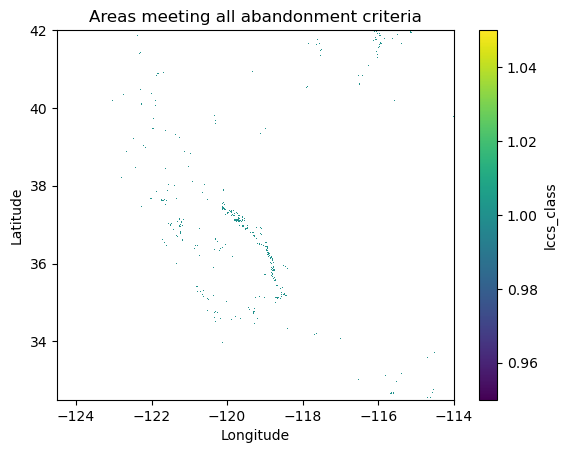

In [12]:
# Plot the final mask where it's True
import matplotlib.pyplot as plt
final_mask.where(final_mask).plot(cmap='viridis')
plt.title('Areas meeting all abandonment criteria')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Processing pixels:   0%|          | 0/31493 [00:00<?, ?it/s]

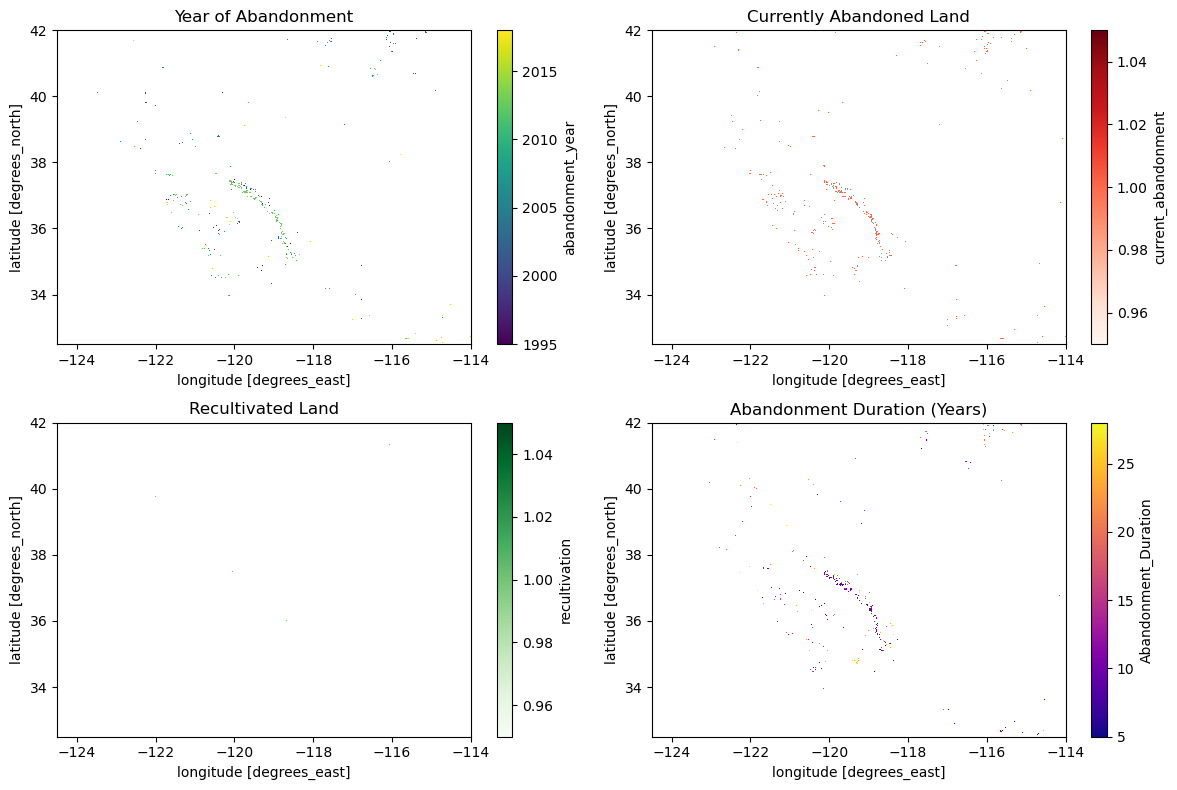

In [31]:
# Implement the abandonment calculation algorithm
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm
# Create arrays to store results
abandonment_year = np.full_like(ds_ca['lccs_class'].isel(time=0).values, np.nan, dtype=float)
abandonment_duration = np.full_like(ds_ca['lccs_class'].isel(time=0).values, np.nan, dtype=float)
recultivation = np.zeros_like(ds_ca['lccs_class'].isel(time=0).values, dtype=bool)
current_abandonment = np.zeros_like(ds_ca['lccs_class'].isel(time=0).values, dtype=bool)

# Get time values as years
years = ds_ca.time.dt.year.values

# Get indices of valid pixels using where
valid_indices = np.where(final_mask.values)



for i in tqdm(range(len(valid_indices[0])), desc="Processing pixels"):
    y, x = valid_indices[0][i], valid_indices[1][i]
    
    duration = 0
    abandonment_start = None
    
    # Process the time series for this pixel
    for t in range(len(years)):
        is_crop = is_cropland.isel(time=t).values[y, x]
        is_nonart = is_non_artificial.isel(time=t).values[y, x]
        
        if is_crop:
            # If previously abandoned for 5+ years, mark as recultivated
            if abandonment_start is not None and duration >= 5:
                recultivation[y, x] = True
                abandonment_year[y, x] = abandonment_start
                abandonment_duration[y, x] = duration
            # Reset tracking for cropland
            abandonment_start = None
            duration = 0
        elif is_nonart:
            # Start tracking abandonment if not already and previous year was cropland
            if abandonment_start is None and t > 0 and is_cropland.isel(time=t-1).values[y, x]:
                abandonment_start = years[t]
            
            # Increment duration if we're tracking abandonment
            if abandonment_start is not None:
                duration += 1
        else:
            # Reset if artificial land
            abandonment_start = None
            duration = 0
    
    # After processing all years, check if currently abandoned (2022)
    if abandonment_start is not None and duration >= 5:
        current_abandonment[y, x] = True
        abandonment_year[y, x] = abandonment_start
        abandonment_duration[y, x] = duration

# Convert results to DataArrays with the same coordinates as the input
abandonment_year_da = xr.DataArray(
    abandonment_year,
    coords=ds_ca['lccs_class'].isel(time=0).coords,
    dims=ds_ca['lccs_class'].isel(time=0).dims,
    name='abandonment_year'
)

recultivation_da = xr.DataArray(
    recultivation,
    coords=ds_ca['lccs_class'].isel(time=0).coords,
    dims=ds_ca['lccs_class'].isel(time=0).dims,
    name='recultivation'
)

current_abandonment_da = xr.DataArray(
    current_abandonment,
    coords=ds_ca['lccs_class'].isel(time=0).coords,
    dims=ds_ca['lccs_class'].isel(time=0).dims,
    name='current_abandonment'
)

abandonment_duration_da = xr.DataArray(
    abandonment_duration,
    coords=ds_ca['lccs_class'].isel(time=0).coords,
    dims=ds_ca['lccs_class'].isel(time=0).dims,
    name='Abandonment_Duration'
)

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
abandonment_year_da.where(~np.isnan(abandonment_year_da)).plot(cmap='viridis')
plt.title('Year of Abandonment')

plt.subplot(2, 2, 2)
current_abandonment_da.where(current_abandonment_da).plot(cmap='Reds')
plt.title('Currently Abandoned Land')

plt.subplot(2, 2, 3)
recultivation_da.where(recultivation_da).plot(cmap='Greens')
plt.title('Recultivated Land')

plt.subplot(2, 2, 4)
abandonment_duration_da.where(abandonment_duration_da > 0).plot(cmap='plasma')
plt.title('Abandonment Duration (Years)')

plt.tight_layout()

# Create new dataset with results




In [33]:
# Create a new dataset with all the results
results_ds = xr.Dataset(
    data_vars={
        'current_abandonment': current_abandonment_da,
        'recultivation': recultivation_da,
        'abandonment_year': abandonment_year_da,
        'Abandonment_Duration':abandonment_duration_da
    }
)

results_ds

<xarray.Dataset> Size: 233MB
Dimensions:               (lat: 3420, lon: 3780)
Coordinates:
  * lat                   (lat) float64 27kB 42.0 42.0 41.99 ... 32.51 32.5 32.5
  * lon                   (lon) float64 30kB -124.5 -124.5 ... -114.0 -114.0
    time                  datetime64[ns] 8B 1992-01-01
Data variables:
    current_abandonment   (lat, lon) bool 13MB False False False ... False False
    recultivation         (lat, lon) bool 13MB False False False ... False False
    abandonment_year      (lat, lon) float64 103MB nan nan nan ... nan nan nan
    Abandonment_Duration  (lat, lon) float64 103MB nan nan nan ... nan nan nan

In [34]:
# Find coordinates where recultivation is True
recultivation_coords = np.where(results_ds['recultivation'].values)
if len(recultivation_coords[0]) > 0:
    # Get the first coordinate where recultivation is True
    first_idx = 0
    lat_idx, lon_idx = recultivation_coords[0][first_idx], recultivation_coords[1][first_idx]
    
    # Get the actual lat/lon values
    lat_value = results_ds.lat.values[lat_idx]
    lon_value = results_ds.lon.values[lon_idx]
    
    print(f"Recultivation is True at coordinate: lat={lat_value}, lon={lon_value}")
    
    # Verify the value at this coordinate
    point = results_ds['recultivation'].sel(lat=lat_value, lon=lon_value, method='nearest')
    print(f"Recultivation value at this point: {point.values}")
else:
    print("No coordinates found where recultivation is True")


Recultivation is True at coordinate: lat=41.90694444444446, lon=-115.0736111111111
Recultivation value at this point: True


Land cover class sequence at lat=41.90694444444446, lon=-115.0736111111111:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 1. 1. 1. 1.]


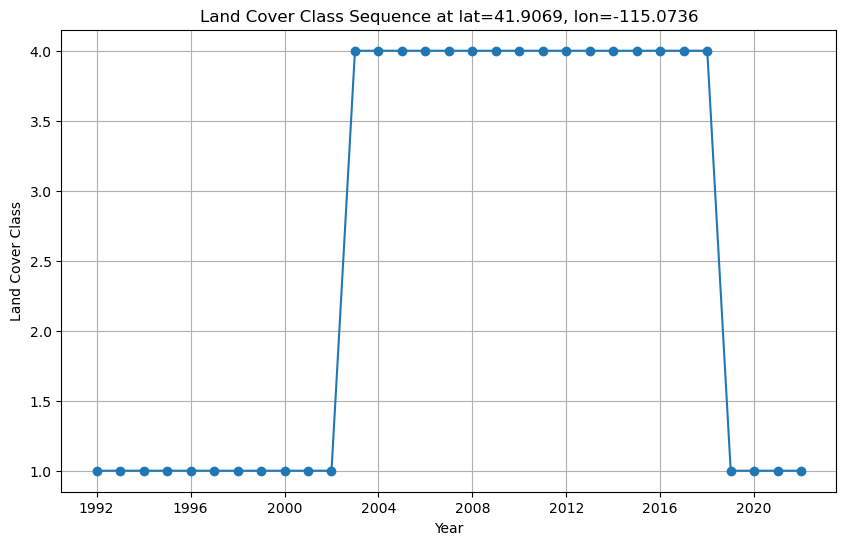

Abandonment year: 2003.0
Abandonment duration: 16.0


In [35]:
# Get the sequence of land cover classes for the example coordinate
if 'lat_value' in locals() and 'lon_value' in locals():
    # Extract the time series of land cover classes at this location
    time_series = ca_ds['lccs_class'].sel(lat=lat_value, lon=lon_value, method='nearest')
    
    print(f"Land cover class sequence at lat={lat_value}, lon={lon_value}:")
    print(time_series.values)
    
    # Visualize the time series
    plt.figure(figsize=(10, 6))
    plt.plot(time_series.time.values, time_series.values, 'o-')
    plt.title(f'Land Cover Class Sequence at lat={lat_value:.4f}, lon={lon_value:.4f}')
    plt.xlabel('Year')
    plt.ylabel('Land Cover Class')
    plt.grid(True)
    plt.show()
    
    # Show abandonment and recultivation information for this point
    print(f"Abandonment year: {results_ds['abandonment_year'].sel(lat=lat_value, lon=lon_value, method='nearest').values}")
    print(f"Abandonment duration: {results_ds['Abandonment_Duration'].sel(lat=lat_value, lon=lon_value, method='nearest').values}")
else:
    print("No example coordinates available")






#### (2) Microclimate-informed PV efficiency model 



### Perform globally

In [ ]:
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm

# Try opening with explicit engine specification
ds_glb = xr.open_dataset('output/recalss_lccs.nc', engine='netcdf4')

ds_glb

# Process in chunks to avoid memory issues
chunk_size = 1000  # Adjust based on available memory
lat_chunks = range(0, len(ds_glb.lat), chunk_size)
lon_chunks = range(0, len(ds_glb.lon), chunk_size)

# Create an empty dataset to store the final mask
final_mask_ds = xr.Dataset(
    data_vars={
        'final_mask': (('lat', 'lon'), np.zeros((len(ds_glb.lat), len(ds_glb.lon)), dtype=bool))
    },
    coords={
        'lat': ds_glb.lat,
        'lon': ds_glb.lon
    }
)

# Process data in chunks
for lat_start in tqdm(lat_chunks, desc="Processing latitude chunks"):
    lat_end = min(lat_start + chunk_size, len(ds_glb.lat))
    
    for lon_start in tqdm(lon_chunks, desc=f"Processing longitude chunks for lat {lat_start}-{lat_end}", leave=False):
        lon_end = min(lon_start + chunk_size, len(ds_glb.lon))
        
        # Load chunk into memory
        chunk = ds_glb.isel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))
        
        # Calculate conditions for this chunk
        is_cropland = (chunk.lccs_class == 1)
        is_builtup = (chunk.lccs_class == 7)
        is_non_artificial = ~(is_cropland | is_builtup)
        
        # C1: Count how many years each pixel is non-artificial; require >= 5
        cond1 = (is_non_artificial.sum(dim='time') >= 5)
        
        # C2: Check if at least one time-slice is cropland
        cond2 = is_cropland.any(dim='time')
        
        # C3: Check for any sequence where cropland is followed by 2 years of non-artificial land
        cond3 = xr.zeros_like(cond1)
        for t in range(len(chunk.time) - 2):
            crop_t = is_cropland.isel(time=t)
            nonart_t1 = is_non_artificial.isel(time=t+1)
            nonart_t2 = is_non_artificial.isel(time=t+2)
            cond3 = cond3 | (crop_t & nonart_t1 & nonart_t2)
        
        # C4: Check for 5 consecutive years of non-artificial land
        cond4 = xr.zeros_like(cond1)
        for t in range(len(chunk.time) - 4):
            consecutive_nonart = (
                is_non_artificial.isel(time=t) &
                is_non_artificial.isel(time=t+1) &
                is_non_artificial.isel(time=t+2) &
                is_non_artificial.isel(time=t+3) &
                is_non_artificial.isel(time=t+4)
            )
            cond4 = cond4 | consecutive_nonart
        
        # Combine all conditions
        chunk_mask = cond1 & cond2 & cond3 & cond4
        
        # Update the final mask with this chunk's results
        final_mask_ds['final_mask'].loc[dict(
            lat=slice(chunk.lat[0].item(), chunk.lat[-1].item()),
            lon=slice(chunk.lon[0].item(), chunk.lon[-1].item())
        )] = chunk_mask.values
        
        # Clear memory
        del chunk, is_cropland, is_builtup, is_non_artificial, cond1, cond2, cond3, cond4, chunk_mask

final_mask_ds.to_netcdf('final_mask.nc')
print("Final mask saved to 'final_mask.nc'")


Mask dimensions: FrozenMappingWarningOnValuesAccess({'lat': 64800, 'lon': 129600})


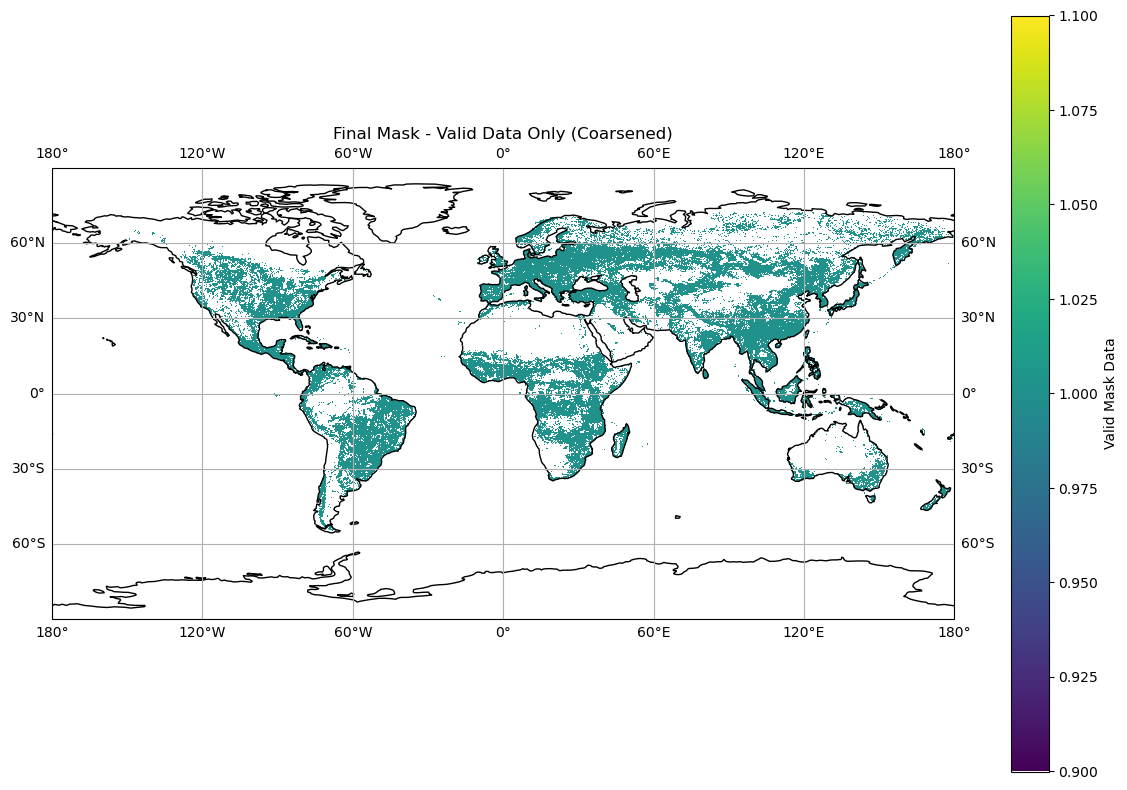

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr

mask_ds = xr.open_dataset('output/final_mask.nc')

# Plot the final mask with a coarser resolution due to large dimensions
print(f"Mask dimensions: {mask_ds.dims}")

coarsen_factor = 100

# Coarsen the mask by taking the mean over blocks
coarse_mask = mask_ds.coarsen(lat=coarsen_factor, lon=coarsen_factor, boundary='trim').mean()

# Convert to boolean or numeric type before applying inversion
# This fixes the TypeError with the invert (~) operation
mask_values = coarse_mask.final_mask.values.astype(bool)

# Create a masked array where invalid data (False values) are masked
masked_data = np.ma.masked_where(~mask_values, mask_values)

# Plot only the valid data
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Use pcolormesh to plot only valid data
im = ax.pcolormesh(coarse_mask.lon, coarse_mask.lat, masked_data, 
                  transform=ccrs.PlateCarree(),
                  cmap='viridis')

# Add a colorbar
plt.colorbar(im, ax=ax, label='Valid Mask Data')

# Add coastlines and gridlines for reference
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_title('Final Mask - Valid Data Only (Coarsened)')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import xarray as xr
from tqdm.notebook import tqdm
import gc
import os
import dask.array as da

# Load the final mask from the saved file
final_mask_ds = xr.open_dataset('output/final_mask.nc')
final_mask = final_mask_ds['final_mask']

# Load the global dataset with chunking to avoid memory issues
ds_glb = xr.open_dataset('output/recalss_lccs.nc', chunks={'time': 1, 'lat': 500, 'lon': 500})

# Get time values as years
years = ds_glb.time.dt.year.values

# Process in smaller chunks to avoid memory issues
chunk_size_lat = 500
chunk_size_lon = 500
lat_chunks = range(0, ds_glb.sizes['lat'], chunk_size_lat)
lon_chunks = range(0, ds_glb.sizes['lon'], chunk_size_lon)

# Create output file path
output_file = 'output/abandonment_analysis.nc'

# Get dimensions
lat_size = ds_glb.sizes['lat']
lon_size = ds_glb.sizes['lon']

# Instead of creating large arrays in memory, create dask arrays
# This avoids the MemoryError when allocating large arrays
abandonment_year = da.full((lat_size, lon_size), np.nan, dtype=np.float32)  # Using float32 instead of float64
abandonment_duration = da.full((lat_size, lon_size), np.nan, dtype=np.float32)  # Using float32 instead of float64
recultivation = da.zeros((lat_size, lon_size), dtype=bool)
current_abandonment = da.zeros((lat_size, lon_size), dtype=bool)

# Get the indices of valid data from final_mask
valid_mask = final_mask.compute()
valid_indices = np.where(valid_mask.values)
valid_pixels = list(zip(valid_indices[0], valid_indices[1]))

# Group valid pixels by chunks to process them efficiently
chunk_pixel_map = {}
for y, x in valid_pixels:
    lat_chunk = y // chunk_size_lat
    lon_chunk = x // chunk_size_lon
    chunk_key = (lat_chunk, lon_chunk)
    
    if chunk_key not in chunk_pixel_map:
        chunk_pixel_map[chunk_key] = []
    
    # Store local coordinates within the chunk
    chunk_pixel_map[chunk_key].append((y % chunk_size_lat, x % chunk_size_lon, y, x))

# Create temporary arrays for each chunk to avoid memory issues
for chunk_key in tqdm(chunk_pixel_map.keys(), desc="Processing chunks with valid data"):
    lat_chunk, lon_chunk = chunk_key
    lat_start = lat_chunk * chunk_size_lat
    lon_start = lon_chunk * chunk_size_lon
    lat_end = min(lat_start + chunk_size_lat, ds_glb.sizes['lat'])
    lon_end = min(lon_start + chunk_size_lon, ds_glb.sizes['lon'])
    
    # Extract chunk
    chunk = ds_glb.isel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))
    
    # Load the chunk data into memory
    chunk = chunk.compute()
    
    # Create temporary arrays for this chunk
    chunk_abandonment_year = np.full((lat_end - lat_start, lon_end - lon_start), np.nan, dtype=np.float32)
    chunk_abandonment_duration = np.full((lat_end - lat_start, lon_end - lon_start), np.nan, dtype=np.float32)
    chunk_recultivation = np.zeros((lat_end - lat_start, lon_end - lon_start), dtype=bool)
    chunk_current_abandonment = np.zeros((lat_end - lat_start, lon_end - lon_start), dtype=bool)
    
    # Pre-compute land cover classifications for the chunk
    is_cropland = (chunk.lccs_class == 1)
    is_builtup = (chunk.lccs_class == 7)
    is_non_artificial = ~(is_cropland | is_builtup)
    
    # Process only valid pixels in this chunk
    for local_y, local_x, global_y, global_x in chunk_pixel_map[chunk_key]:
        duration = 0
        abandonment_start = None
        
        # Process the time series for this pixel
        for t in range(len(years)):
            is_crop = is_cropland.isel(time=t).values[local_y, local_x]
            is_nonart = is_non_artificial.isel(time=t).values[local_y, local_x]
            
            if is_crop:
                # If previously abandoned for 5+ years, mark as recultivated
                if abandonment_start is not None and duration >= 5:
                    chunk_recultivation[local_y, local_x] = True
                    chunk_abandonment_year[local_y, local_x] = abandonment_start
                    chunk_abandonment_duration[local_y, local_x] = duration
                # Reset tracking for cropland
                abandonment_start = None
                duration = 0
            elif is_nonart:
                # Start tracking abandonment if not already and previous year was cropland
                if abandonment_start is None and t > 0 and is_cropland.isel(time=t-1).values[local_y, local_x]:
                    abandonment_start = years[t]
                
                # Increment duration if we're tracking abandonment
                if abandonment_start is not None:
                    duration += 1
            else:
                # Reset if artificial land
                abandonment_start = None
                duration = 0
        
        # After processing all years, check if currently abandoned (2022)
        if abandonment_start is not None and duration >= 5:
            chunk_current_abandonment[local_y, local_x] = True
            chunk_abandonment_year[local_y, local_x] = abandonment_start
            chunk_abandonment_duration[local_y, local_x] = duration
    
    # Create a temporary dataset for this chunk
    chunk_ds = xr.Dataset(
        data_vars={
            'abandonment_year': (('lat', 'lon'), chunk_abandonment_year),
            'Abandonment_Duration': (('lat', 'lon'), chunk_abandonment_duration),
            'recultivation': (('lat', 'lon'), chunk_recultivation),
            'current_abandonment': (('lat', 'lon'), chunk_current_abandonment)
        },
        coords={
            'lat': chunk.lat,
            'lon': chunk.lon
        }
    )
    
    # Save this chunk to a temporary file
    temp_file = f'output/temp_chunk_{lat_chunk}_{lon_chunk}.nc'
    chunk_ds.to_netcdf(temp_file)
    
    # Clear memory
    del chunk, is_cropland, is_builtup, is_non_artificial
    del chunk_abandonment_year, chunk_abandonment_duration, chunk_recultivation, chunk_current_abandonment
    del chunk_ds
    gc.collect()


c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Processing chunks with valid data:   0%|          | 0/6488 [00:00<?, ?it/s]

Combining chunks into final dataset...


Merging chunks:   0%|          | 0/6488 [00:00<?, ?it/s]

NotImplementedError: xarray can't set arrays with multiple array indices to dask yet.

c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Processing mask in chunks...


Processing lat chunks:   0%|          | 0/130 [00:00<?, ?it/s]

Combining chunks into final dataset...


Merging chunks:   0%|          | 0/6488 [00:00<?, ?it/s]

ValueError: assignment destination is read-only